## **Week 5: Building our CNN**
### José Manuel López, Alex Martín, Marcos V. Conde

In [1]:
import tensorflow as tf
import pandas as pd
import warnings
import os
import numpy as np
import gc
import matplotlib.pyplot as plt

from tensorflow.python.util import deprecation
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Dropout, BatchNormalization

Loading Data and TF/Keras GPU setup

In [2]:
DATA_DIR_SMALL = "./datasets/MIT_small_train_{}"
DATA_DIR_BIG = "./datasets/MIT_split"
IMG_SIZE = 64
BATCH_SIZE = 64
RANDOM_SEED = 42
CLASSES = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding']

In [3]:
# Disable Warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# VRAM broke without this
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.config.experimental_run_functions_eagerly(True)

try:
    # print model to see if it's compatible with Mixed Precision
    print(device_lib.list_local_devices()[3].physical_device_desc)
    # Change to TF16 mixed precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
except:
    pass

print(gpus[0])
print(tf.__version__)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.7.1


In [4]:
def get_dataset(path, aug):
    print("Loading: {}".format(path))
    if not aug:
        train_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)

        train_loader = train_datagen.flow_from_directory(
                path+'/train',  
                target_size=(IMG_SIZE, IMG_SIZE), 
                batch_size=BATCH_SIZE,
                classes = CLASSES,
                class_mode='categorical') 

        test_loader = test_datagen.flow_from_directory(
            path+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = CLASSES,
            class_mode='categorical')
        
        return train_loader, test_loader
        
    else:

        train_datagen = ImageDataGenerator(rescale=1./255, featurewise_center = False, samplewise_center = False,
                                           featurewise_std_normalization = False, samplewise_std_normalization = False,
                                           rotation_range = 0.2, width_shift_range = 15, height_shift_range = 15, shear_range = 0.2,
                                           zoom_range = 0.2, fill_mode = "nearest", horizontal_flip = True
                                            )
        test_datagen = ImageDataGenerator(rescale=1./255)

        train_loader = train_datagen.flow_from_directory(
                path+'/train',  
                target_size=(IMG_SIZE, IMG_SIZE), 
                batch_size=BATCH_SIZE,
                classes = CLASSES,
                class_mode='categorical') 

        test_loader = test_datagen.flow_from_directory(
            path+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = CLASSES,
            class_mode='categorical')
        
        return train_loader, test_loader



In [5]:
train_small, test_small = get_dataset(DATA_DIR_SMALL.format(1), aug = True)
train_big, test_big = get_dataset(DATA_DIR_BIG, aug = True)


examples = enumerate(train_big)
batch_idx, (example_data, example_targets) = next(examples)
print("Data Shape: {}".format(example_data.shape))

Loading: ./datasets/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Loading: ./datasets/MIT_split
Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Data Shape: (64, 64, 64, 3)


Building Model and Plotting Results

In [6]:
def build_model(n_conv = 4, kernel_size = 5, conv = 256, n_dense = 2, dense = 1024, max_pool = False, dropout = False, batch_norm = False, opt = "adam"):
    #create model
    model = Sequential()
    #add model layers
    for idx, i in enumerate(range(n_conv)):
        if idx == 0:
            model.add(Conv2D(conv, kernel_size=kernel_size, activation="relu", input_shape=(IMG_SIZE,IMG_SIZE,3)))
            
            if max_pool:
                model.add(MaxPooling2D())
        else:
            model.add(Conv2D(conv, kernel_size=kernel_size, activation="relu"))
        
        if batch_norm:
            model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())

    for i in range(n_dense):
        model.add(Dense(dense, activation="relu"))
        if dropout:
            model.add(Dropout(0.2))
        
        if batch_norm:
            model.add(BatchNormalization())

    model.add(Dense(len(CLASSES), activation="softmax"))

    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=["accuracy"])

    return model



def plot_loss_accuracy(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))
    
    fig.suptitle(title, fontsize=16)

    # Plot history: CrossEntropy
    ax1.plot(history.history['loss'], label='CrossEntropy (training data)')
    ax1.plot(history.history['val_loss'], label='CrossEntropy (validation data)')
    ax1.set_title('Loss Function: Cross Entropy')
    ax1.set(xlabel='Epoch', ylabel='Loss Value')
    ax1.legend(loc="upper left")

    # Plot history: Accuracy
    ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
    ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    ax2.set_title('Accuracy')
    ax2.set(xlabel='Epoch', ylabel='Accuracy Value')
    ax2.legend(loc="upper left")

    plt.show()

In [55]:
experiment = []
results = {"Train Loss": [], "Train Accuracy": [],"Test Loss": [],"Test Accuracy": []}

## Checking Convolutional Layers

#### 1 Convolution Layer

In [8]:
N_CONV  = 1
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

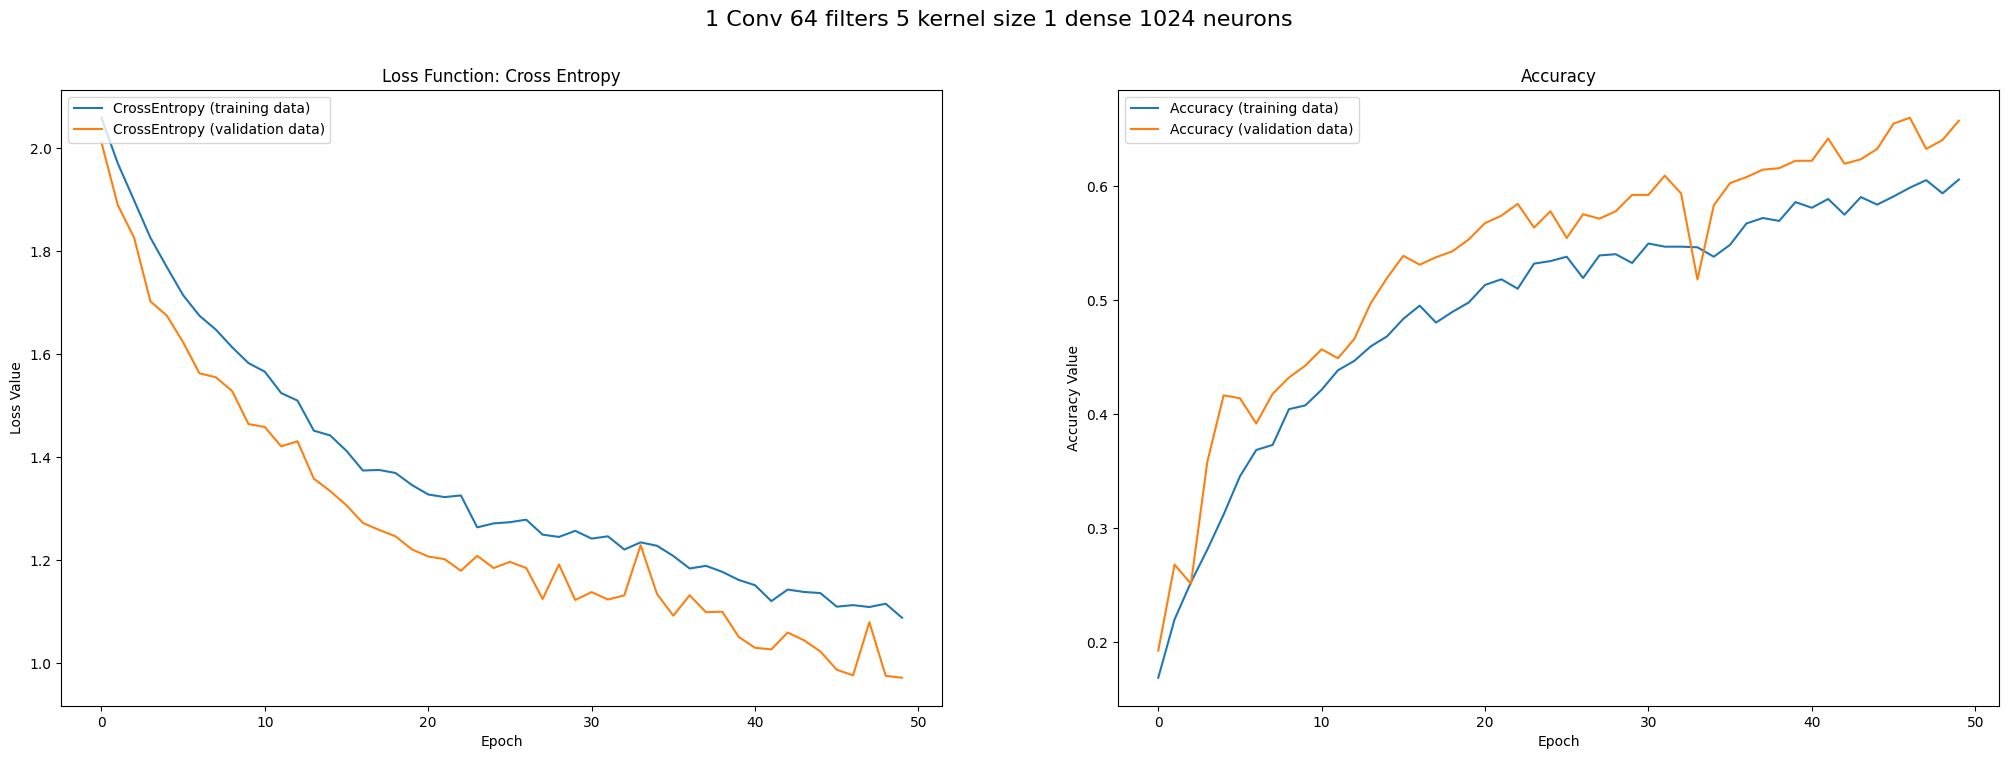

Train Accuracy: 0.6273  Train Loss: 1.0624
Test Accuracy: 0.6605  Test Loss: 0.9706


In [9]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
experiment.append(title)
plot_loss_accuracy(history, title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))


#### 2 Convolution Layer

In [10]:
N_CONV  = 2
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

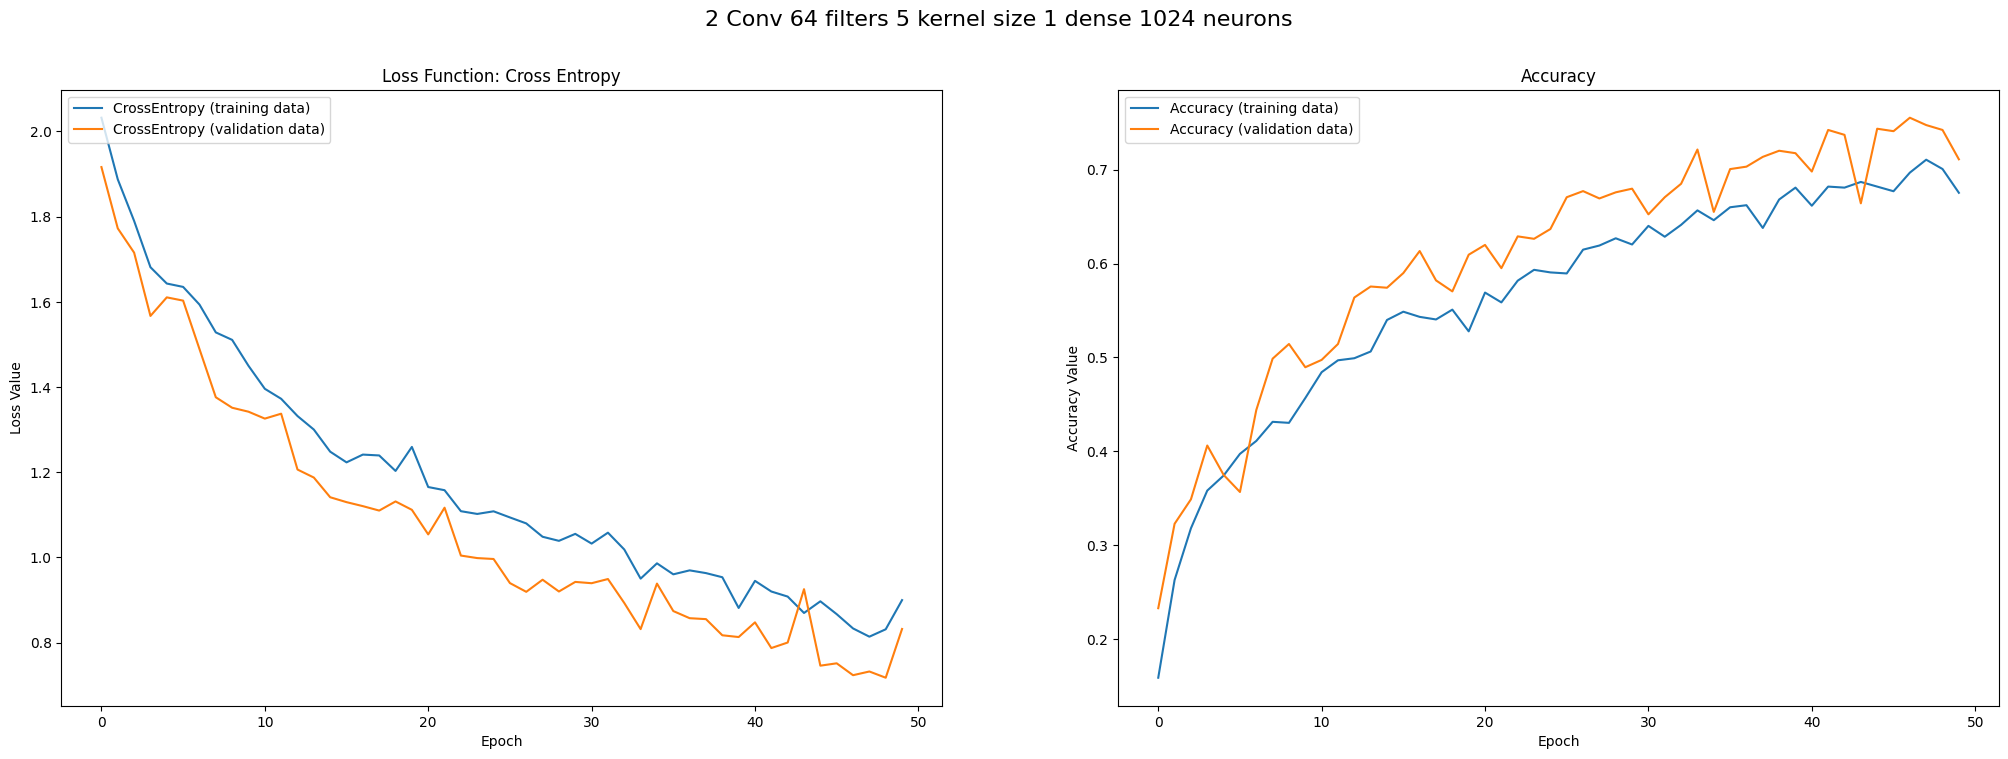

Train Accuracy: 0.6970  Train Loss: 0.8855
Test Accuracy: 0.7076  Test Loss: 0.8397


In [11]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

#### 4 Convolution Layer

In [12]:
N_CONV  = 4
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

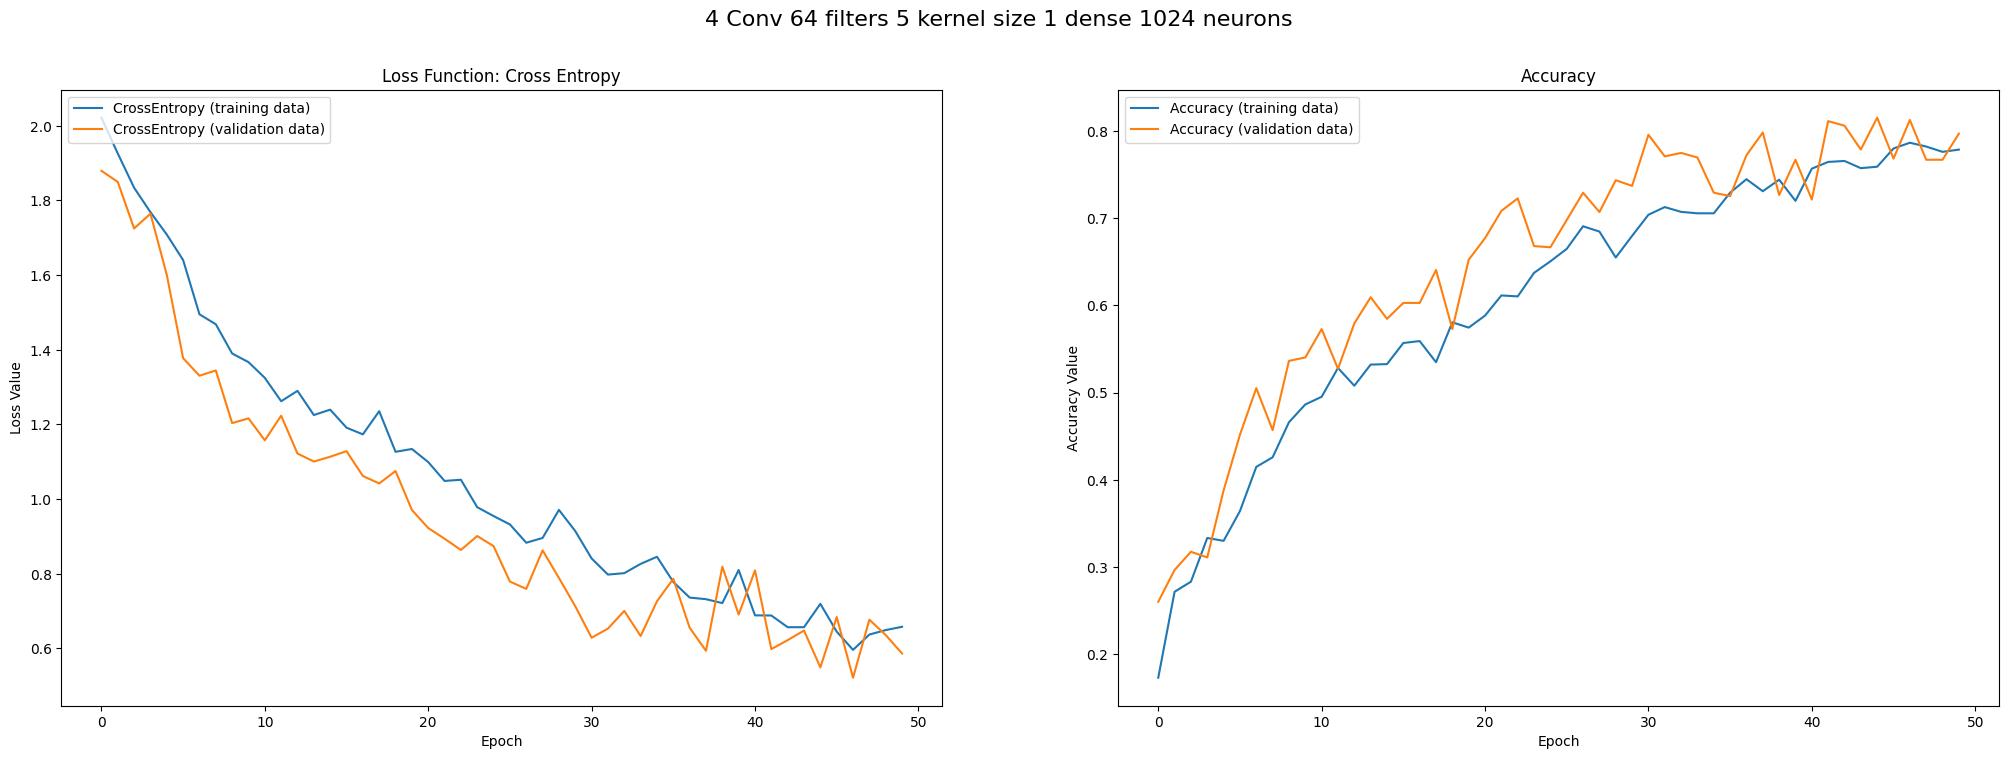

Train Accuracy: 0.8033  Train Loss: 0.5649
Test Accuracy: 0.7968  Test Loss: 0.5880


In [13]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

#### 8 Convolution Layer

In [14]:
N_CONV  = 8
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

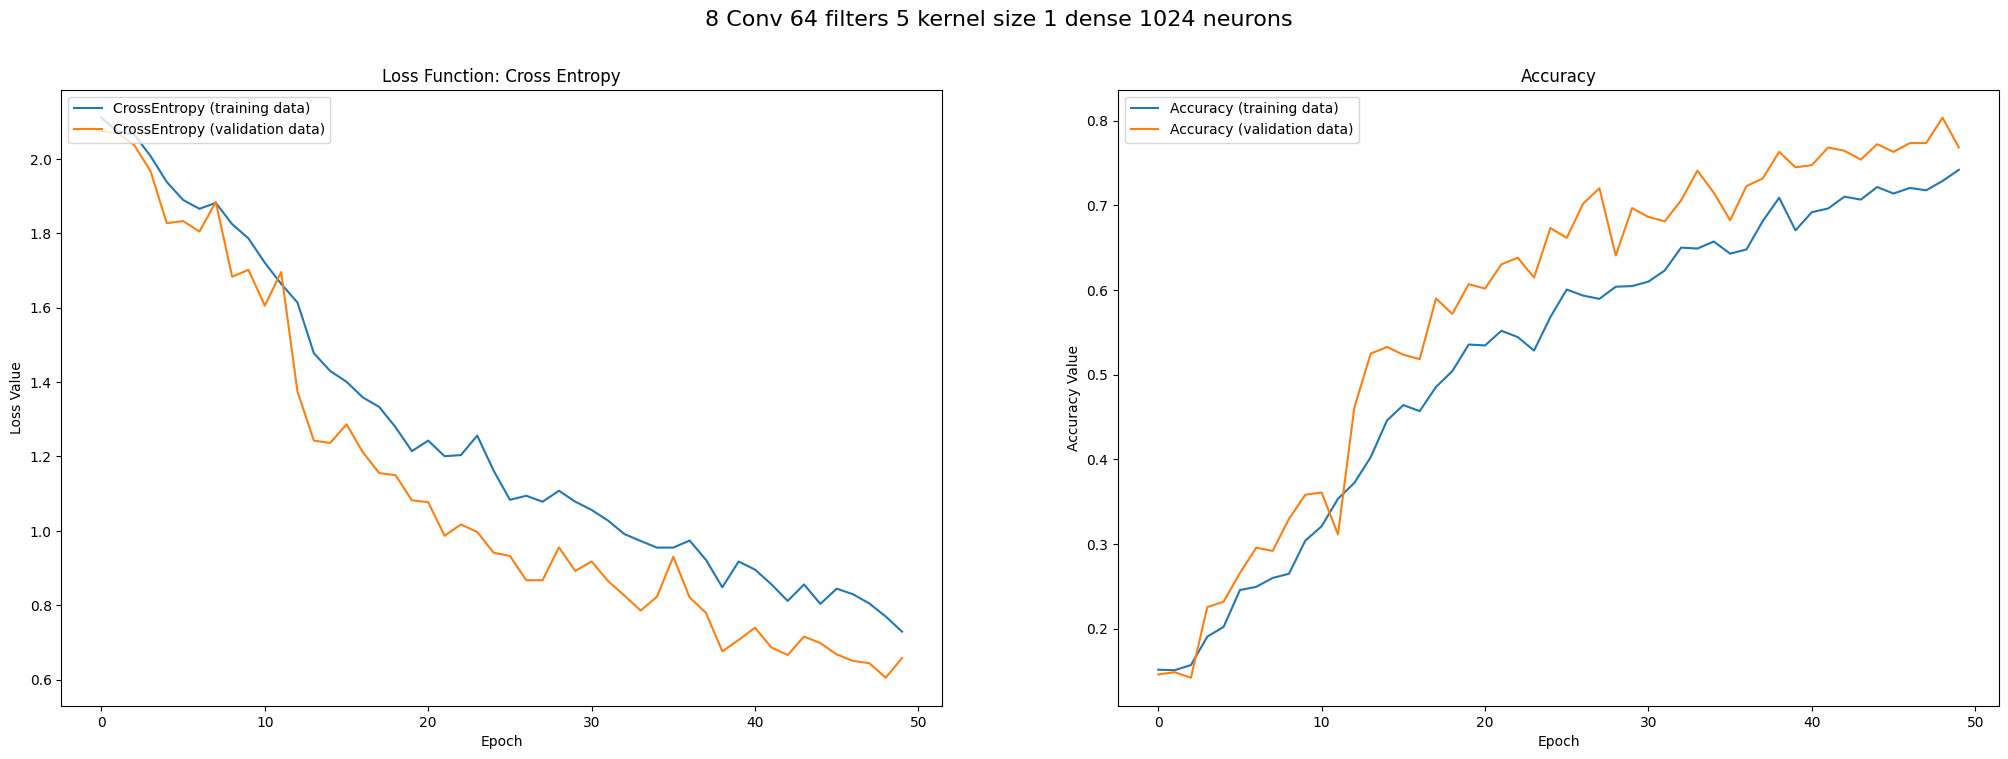

Train Accuracy: 0.7549  Train Loss: 0.7137
Test Accuracy: 0.7646  Test Loss: 0.6602


In [15]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

## Checking Dense Layers

#### 2 Dense Layer

In [16]:
N_CONV  = 4
CONV = 64
KERNEL = 5
N_DENSE = 2
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

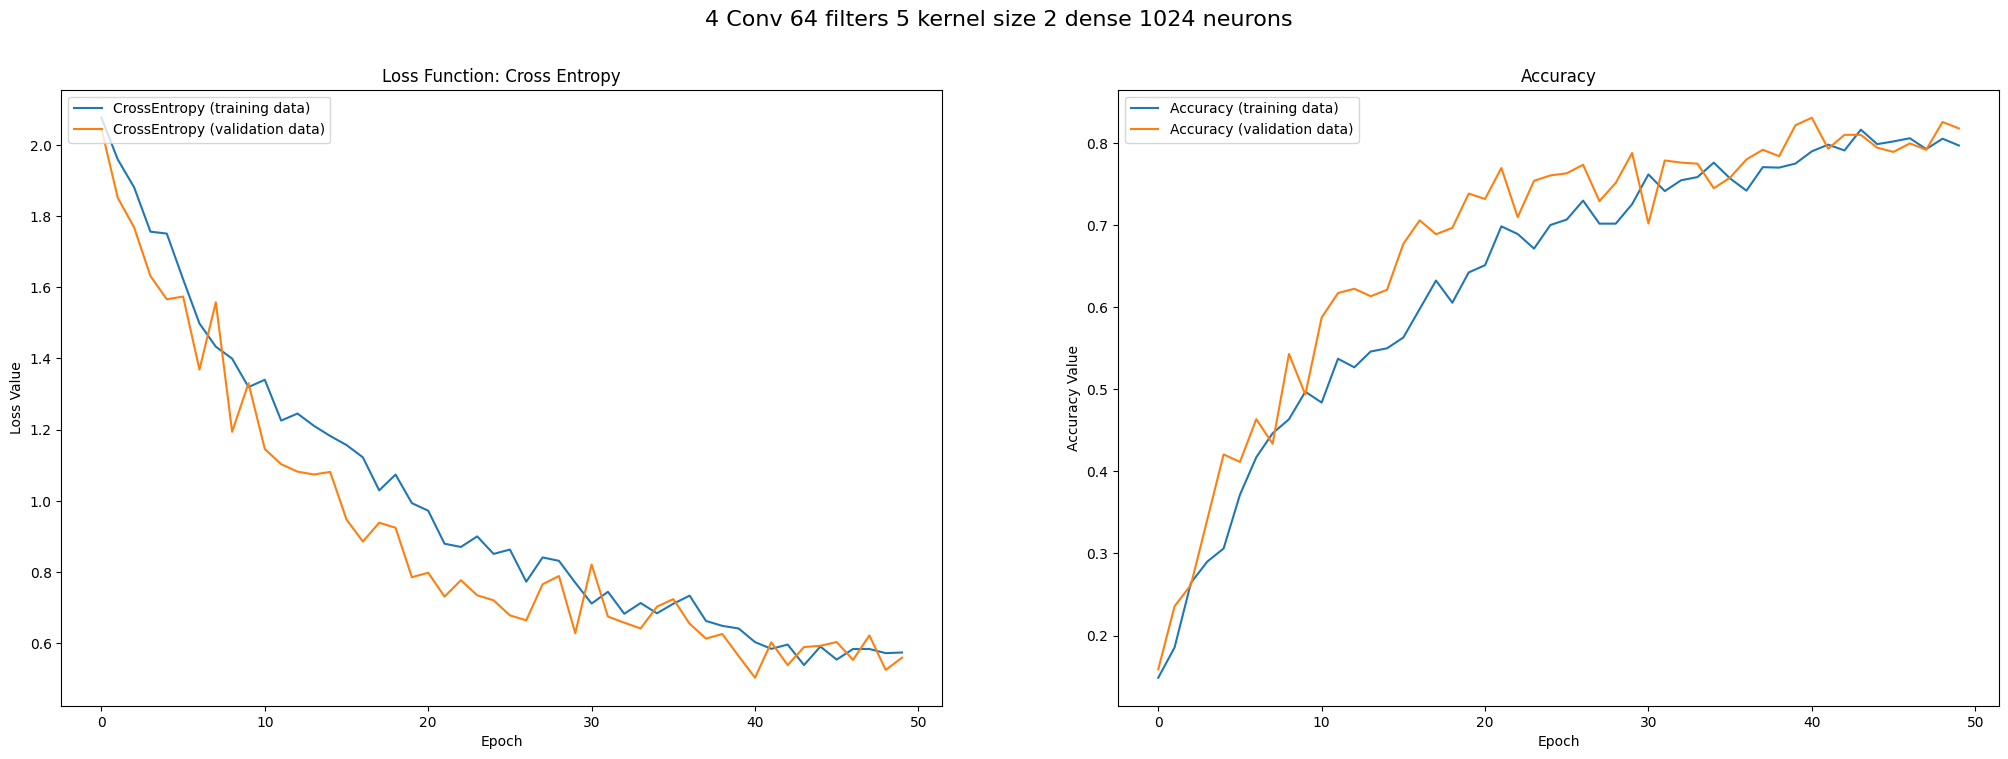

Train Accuracy: 0.8251  Train Loss: 0.5040
Test Accuracy: 0.8191  Test Loss: 0.5628


In [17]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

#### 4 Dense Layer

In [18]:
N_CONV  = 4
CONV = 64
KERNEL = 5
N_DENSE = 4
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

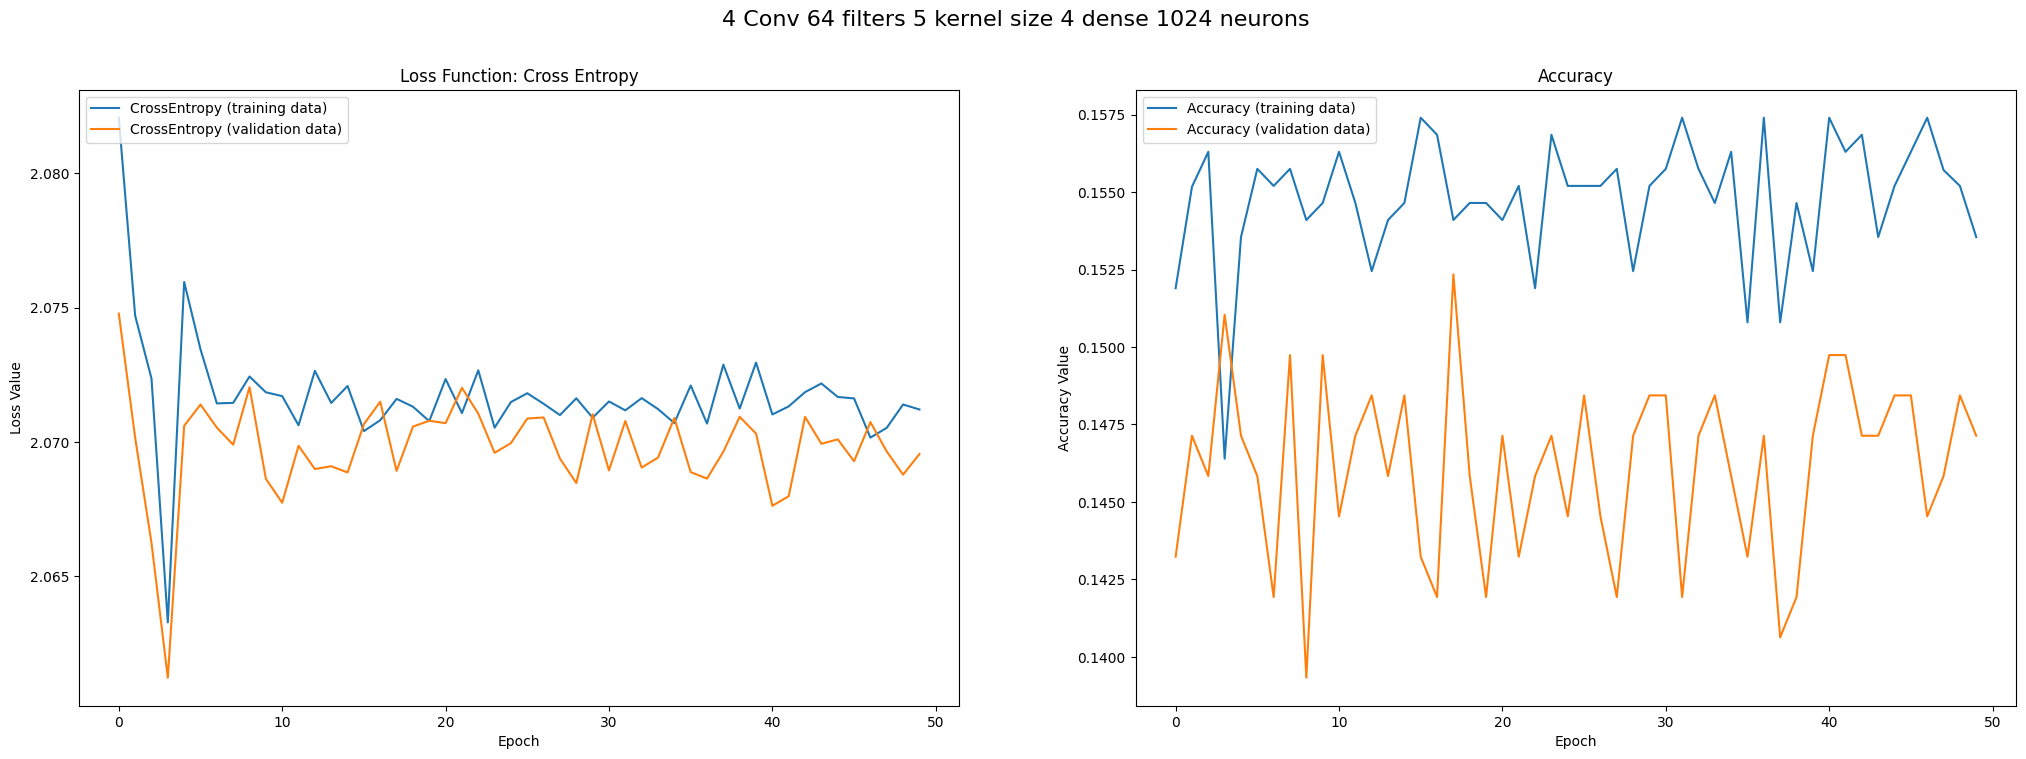

Train Accuracy: 0.1552  Train Loss: 2.0707
Test Accuracy: 0.1462  Test Loss: 2.0698


In [19]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

## Checking Number of Filters

#### 32 Filters

In [20]:
N_CONV  = 4
CONV = 32
KERNEL = 5
N_DENSE = 2
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

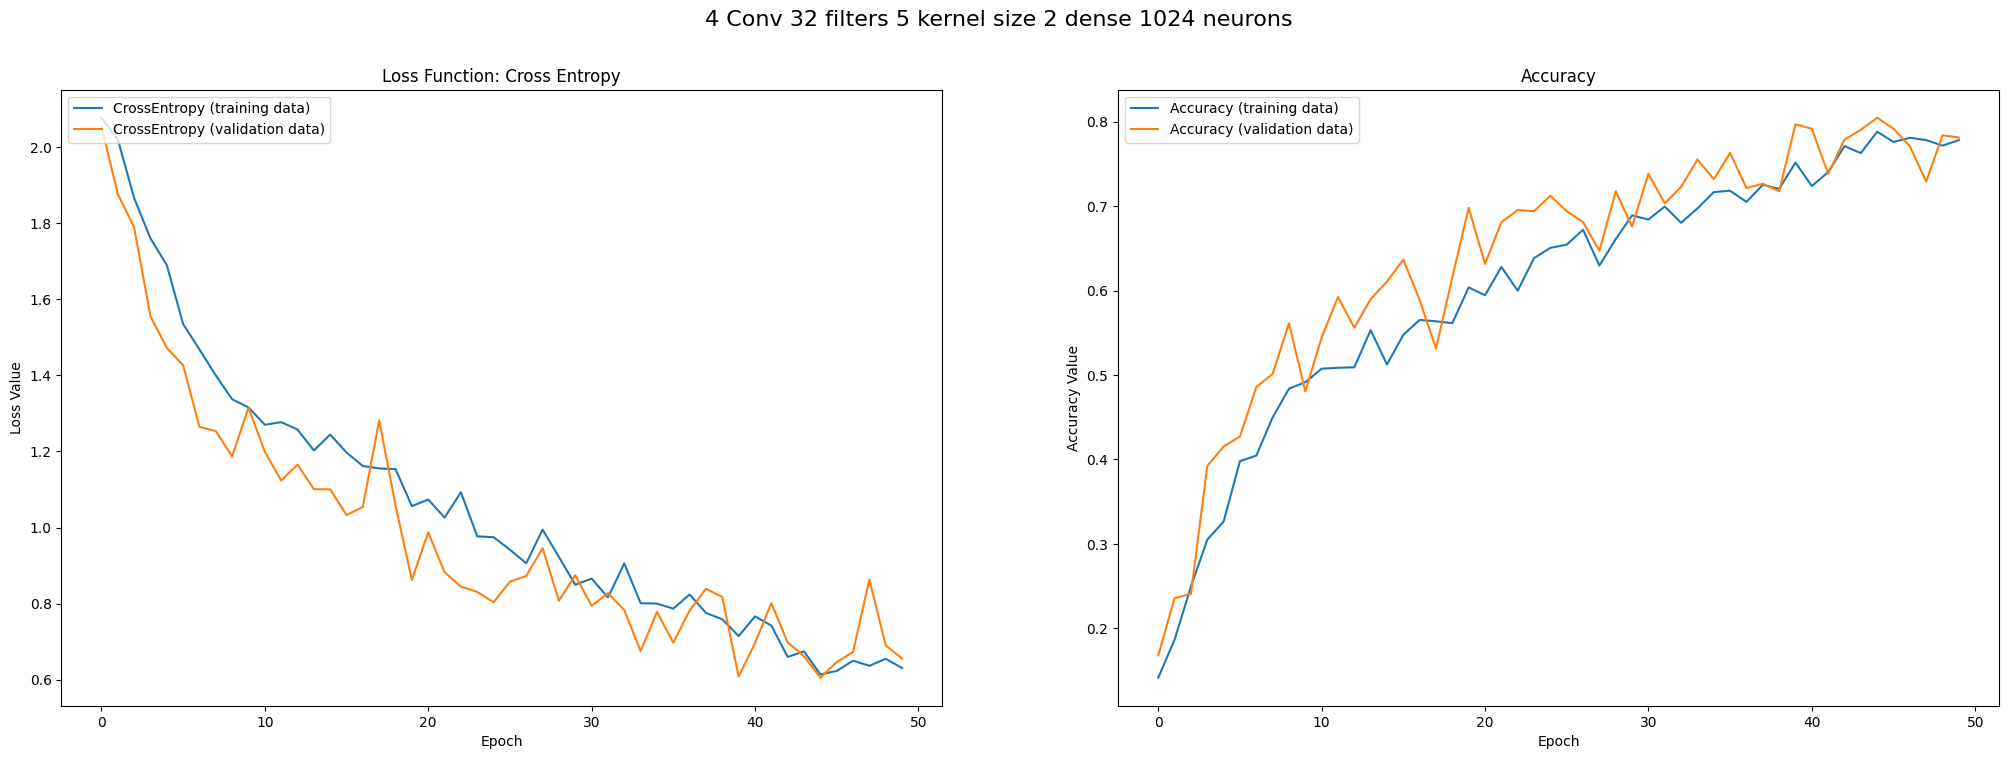

Train Accuracy: 0.7650  Train Loss: 0.6550
Test Accuracy: 0.7794  Test Loss: 0.6572


In [21]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

#### 128 Filters

In [22]:
N_CONV  = 4
CONV = 128
KERNEL = 5
N_DENSE = 2
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

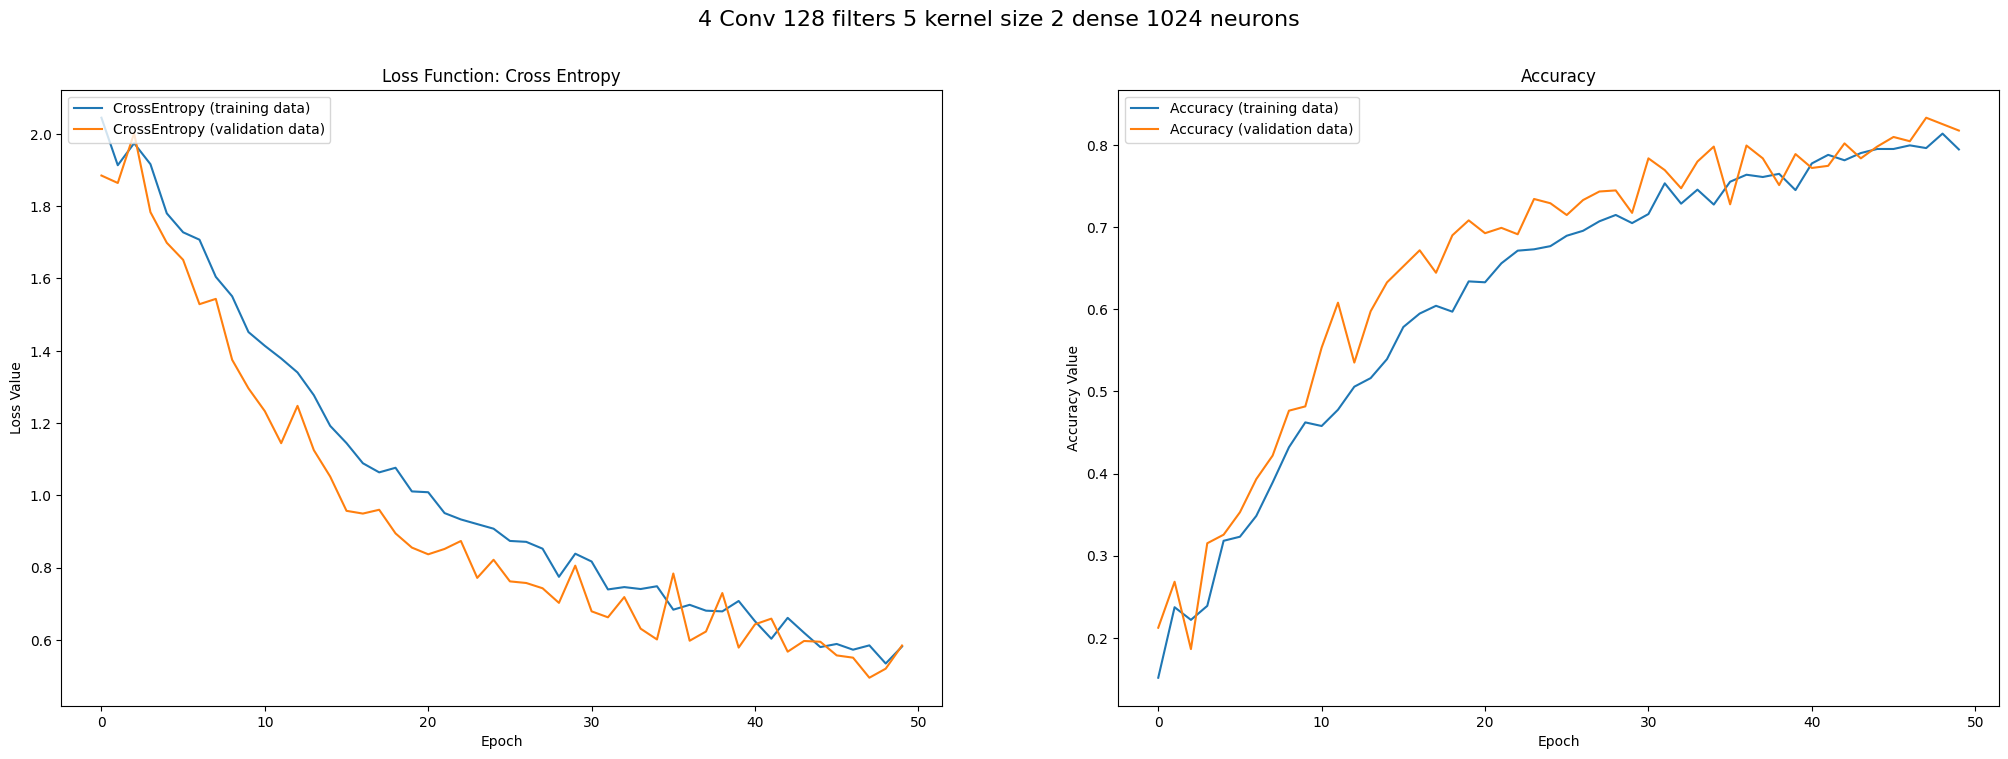

Train Accuracy: 0.8065  Train Loss: 0.5612
Test Accuracy: 0.8178  Test Loss: 0.5847


In [23]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

#### 256 Filters

In [24]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

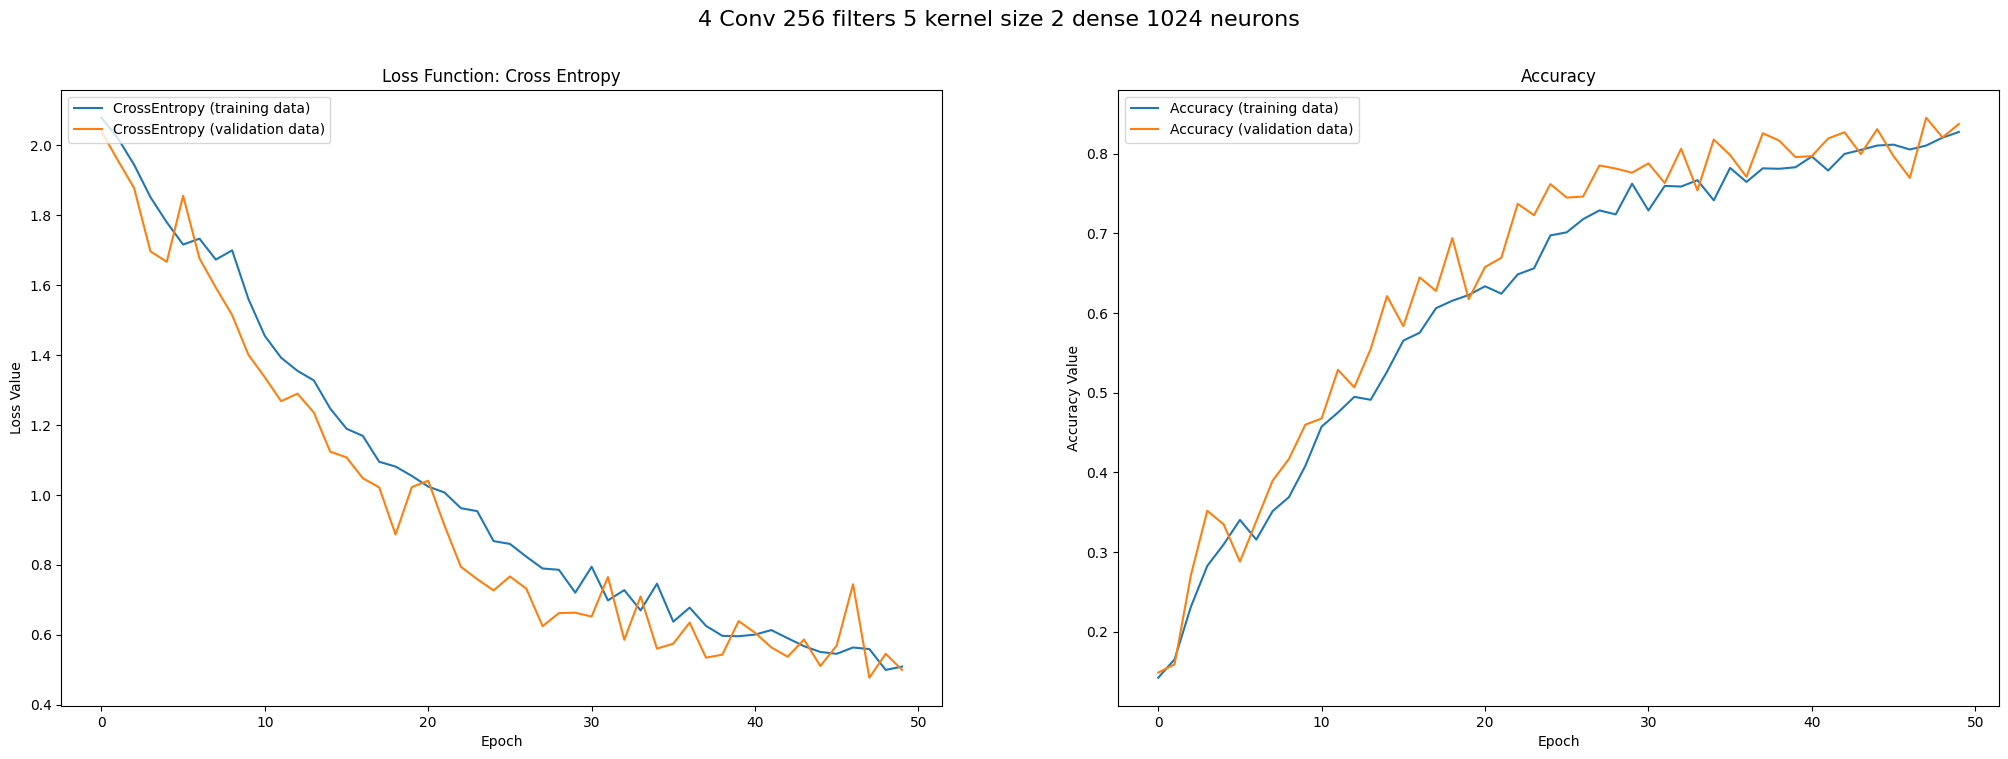

Train Accuracy: 0.8230  Train Loss: 0.5104
Test Accuracy: 0.8340  Test Loss: 0.5113


In [25]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

## Checking Regularization

#### Adding MaxPooling

In [26]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
MAX_POOLING = True

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

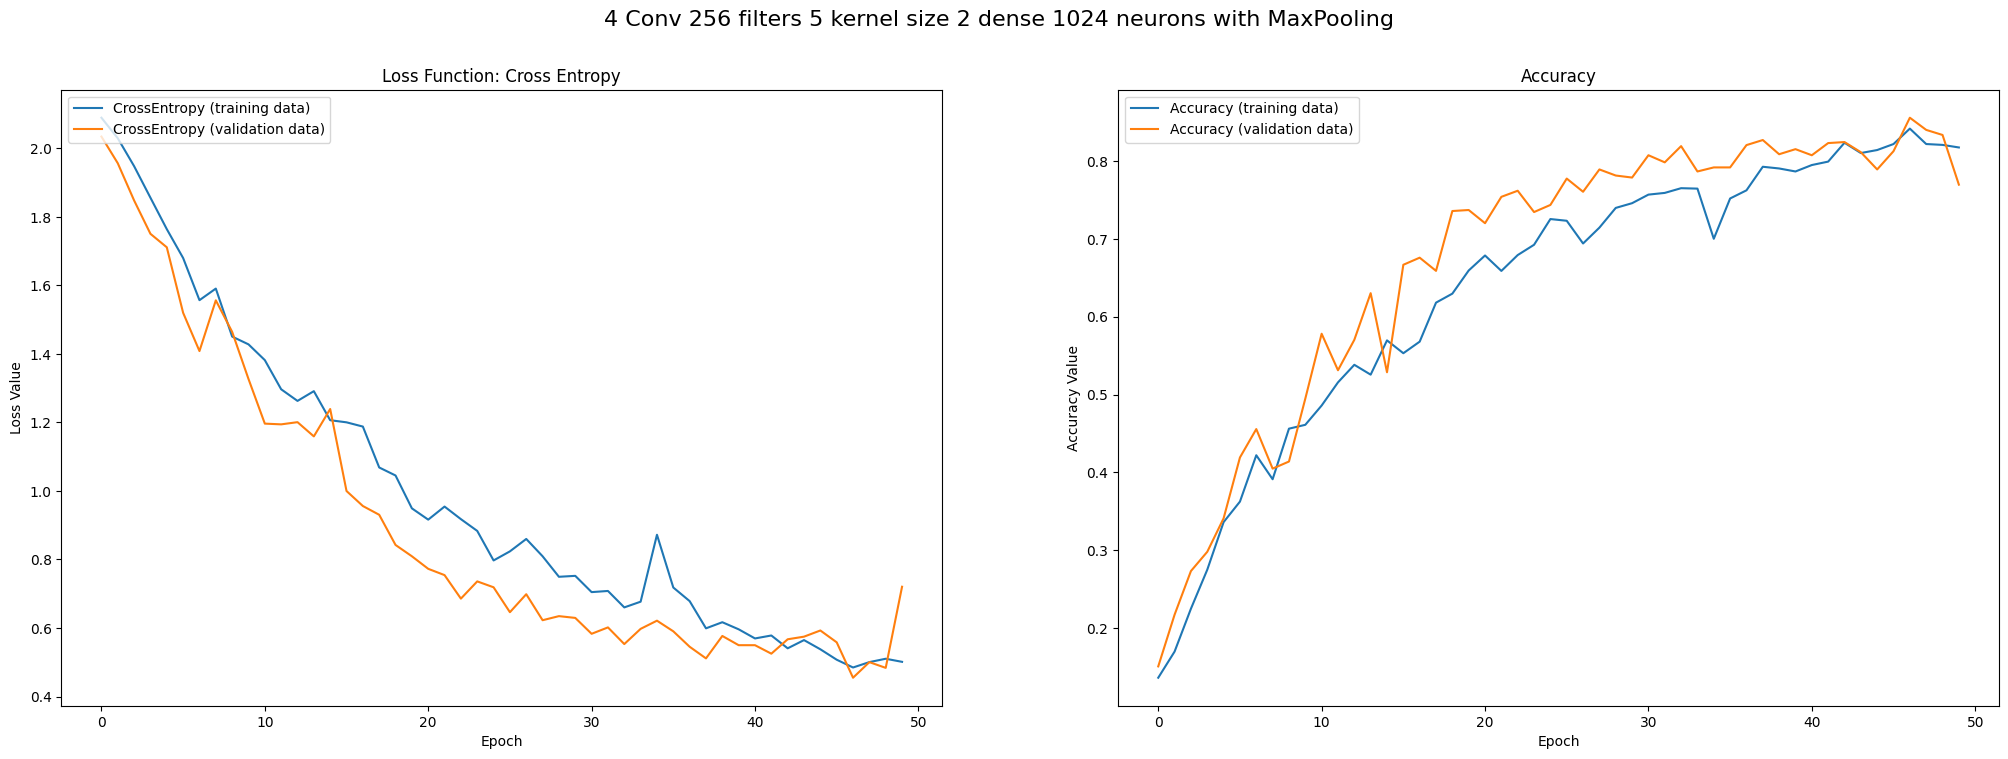

Train Accuracy: 0.7858  Train Loss: 0.6283
Test Accuracy: 0.7732  Test Loss: 0.7044


In [27]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons with MaxPooling".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

#### Adding Dropout

In [28]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
DROPOUT = True

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, dropout = DROPOUT, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

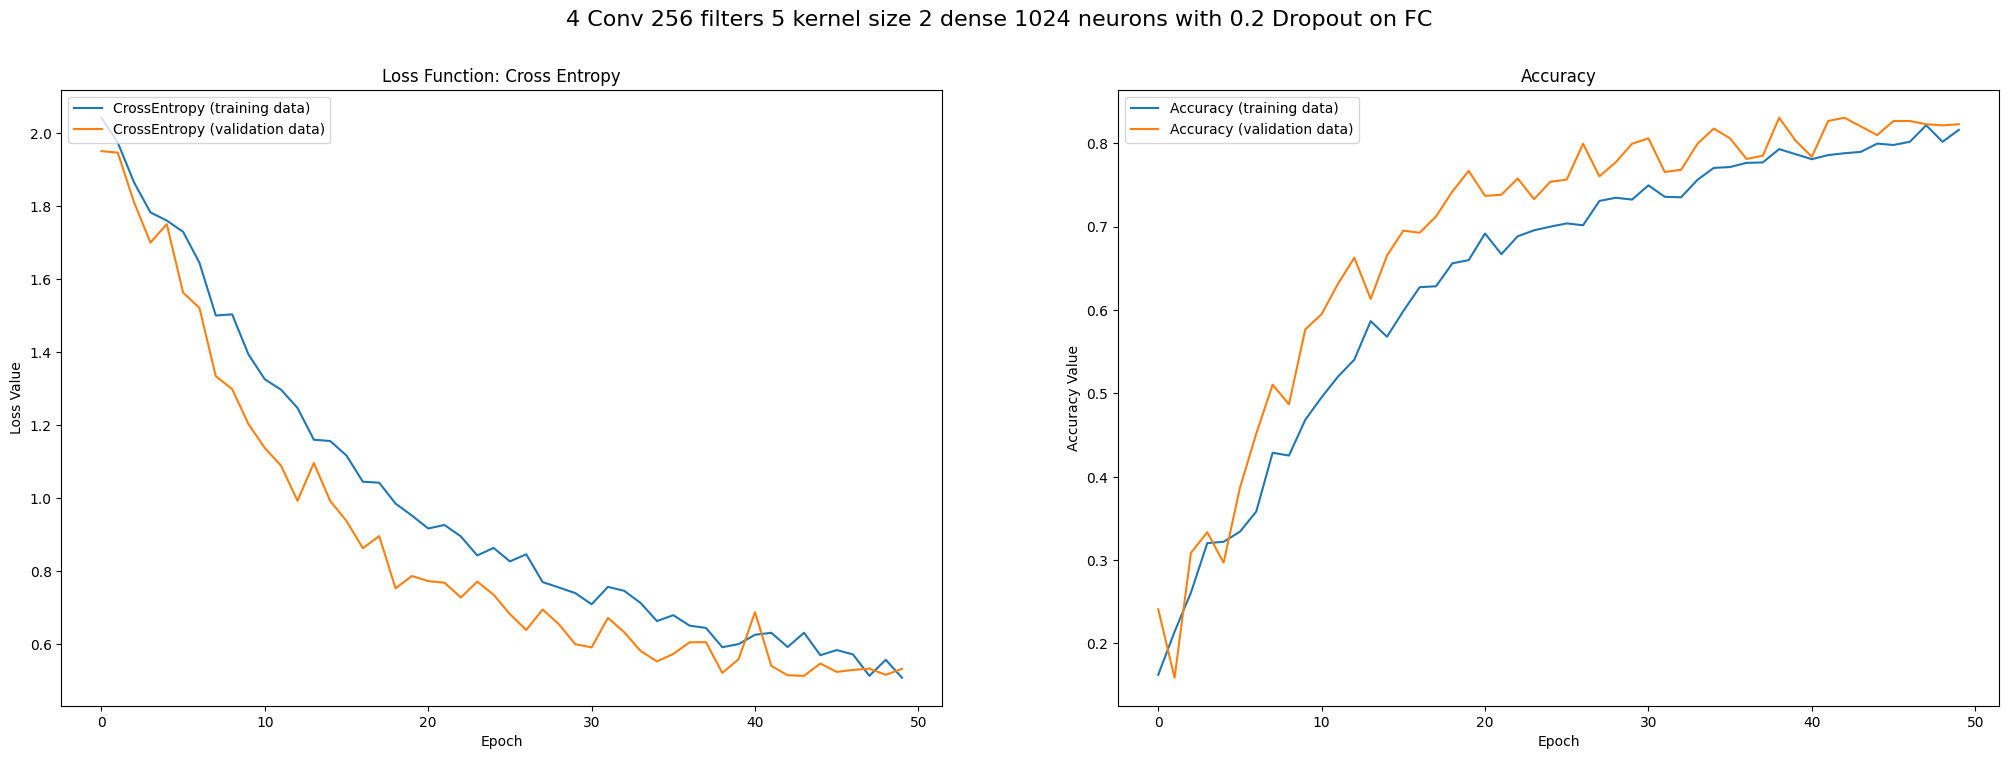

Train Accuracy: 0.8352  Train Loss: 0.4713
Test Accuracy: 0.8216  Test Loss: 0.5341


In [29]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons with 0.2 Dropout on FC".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

#### Adding Batch Normalization

In [30]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
BATCH_NORM = True

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, batch_norm = BATCH_NORM, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

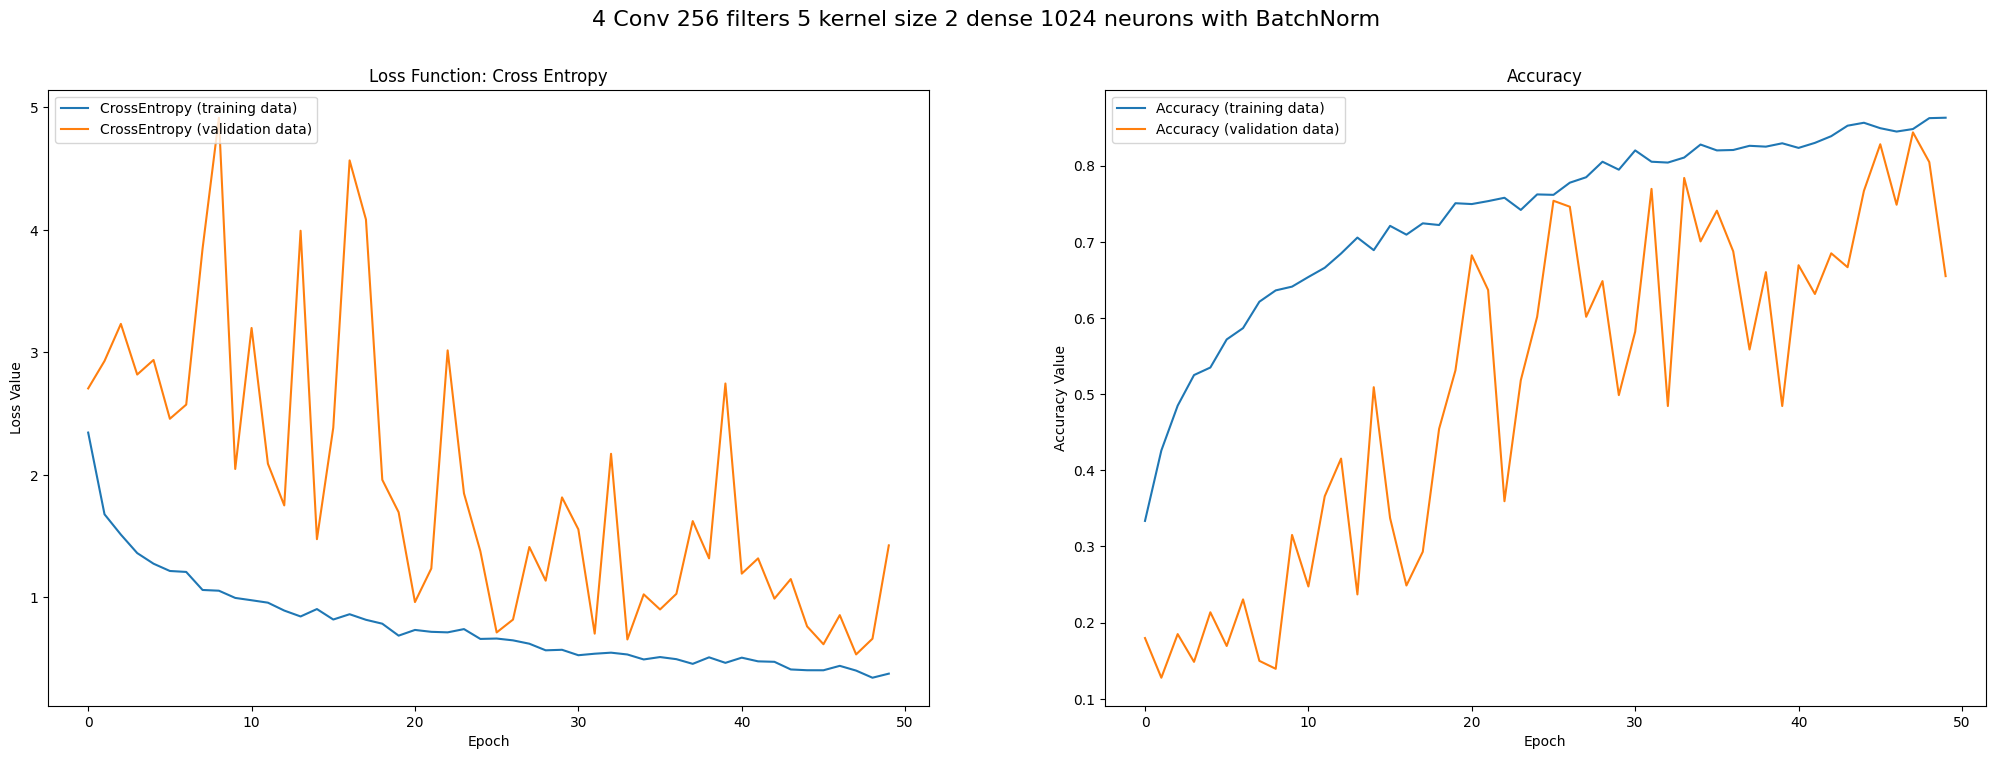

Train Accuracy: 0.6289  Train Loss: 1.4074
Test Accuracy: 0.6555  Test Loss: 1.4211


In [31]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons with BatchNorm".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

#### Adding MaxPooling and Dropout

In [32]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
MAX_POOLING = True
DROPOUT = True

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

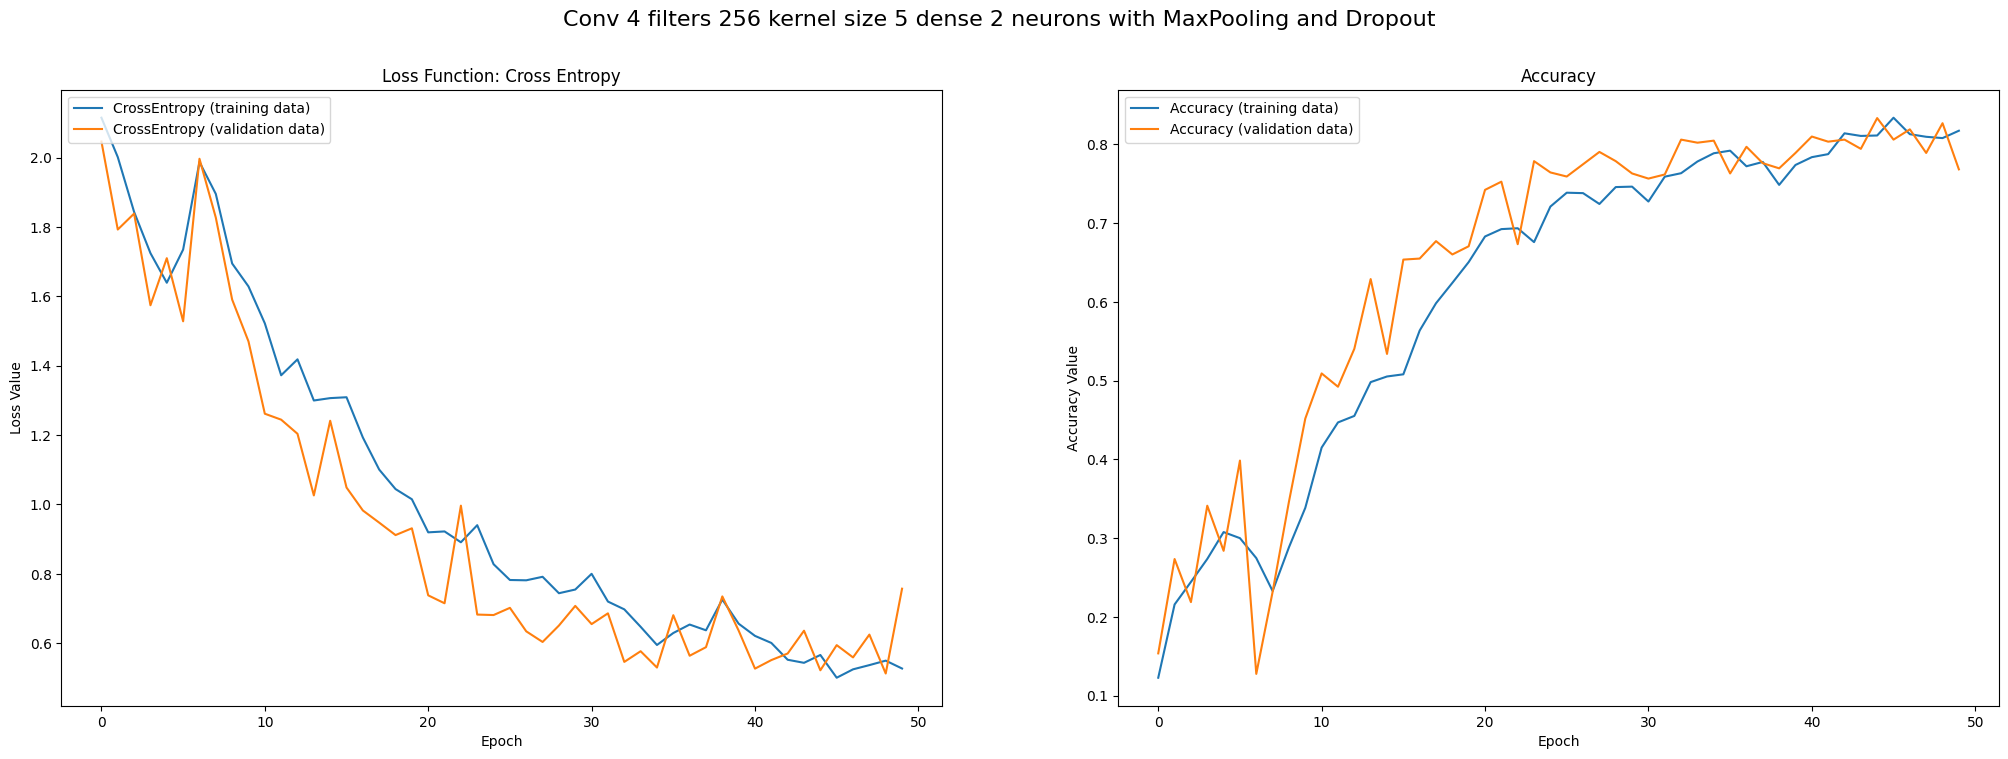

Train Accuracy: 0.7879  Train Loss: 0.5991
Test Accuracy: 0.7683  Test Loss: 0.7568


In [33]:
title = "Conv {} filters {} kernel size {} dense {} neurons with MaxPooling and Dropout".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

#### Adding MaxPooling and Batch Normalization

In [34]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
MAX_POOLING = True
BATCH_NORM = True

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, batch_norm = BATCH_NORM, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

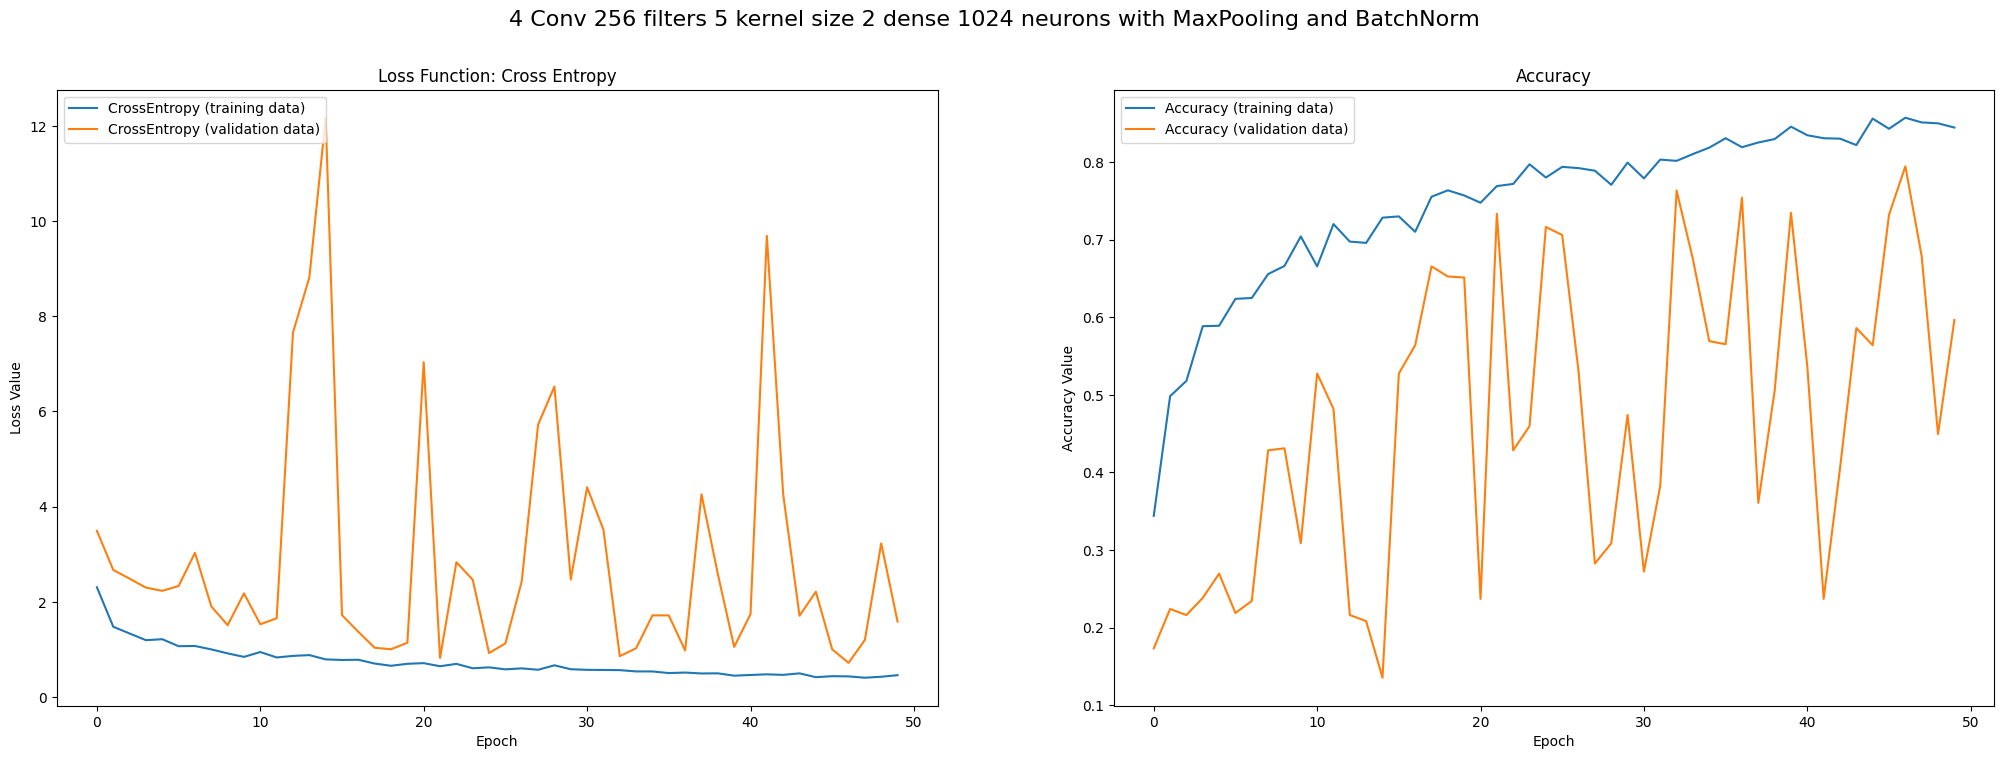

Train Accuracy: 0.6443  Train Loss: 1.2079
Test Accuracy: 0.5948  Test Loss: 1.6041


In [35]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons with MaxPooling and BatchNorm".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

#### Adding Batch Normalization and Dropout

In [36]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
DROPOUT = True
BATCH_NORM = True

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE, verbose = 0)

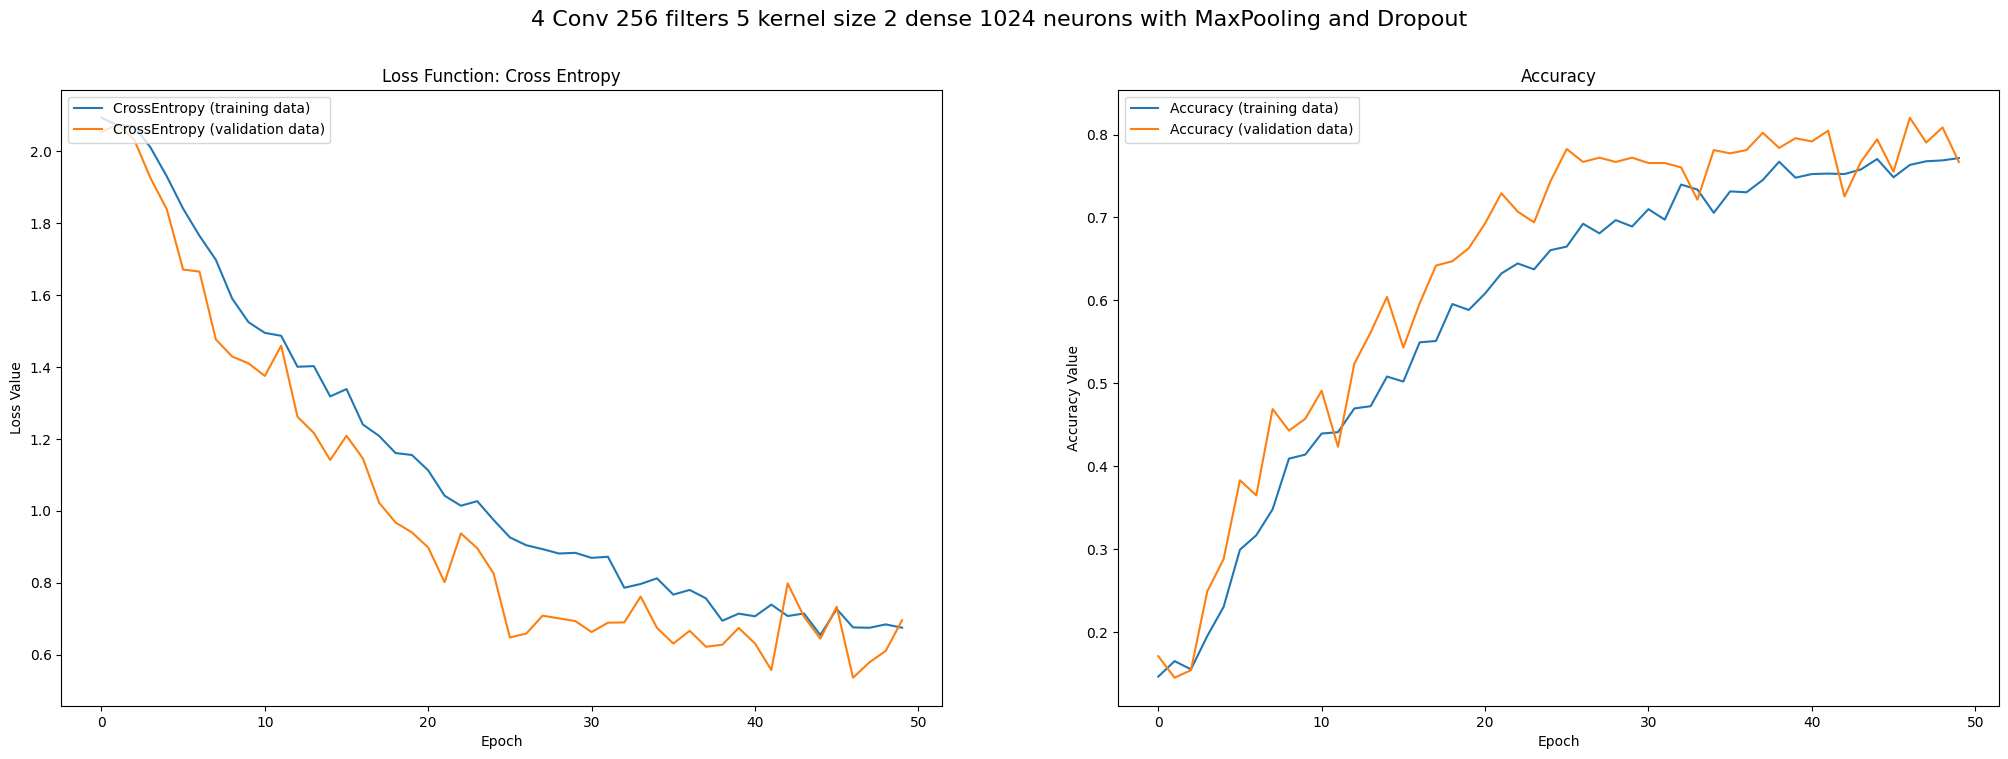

Train Accuracy: 0.7491  Train Loss: 0.6888
Test Accuracy: 0.7670  Test Loss: 0.7082


In [37]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons with MaxPooling and Dropout".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

#### Adding Batch Normalization, MaxPooling and Dropout

In [39]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
DROPOUT = True
BATCH_NORM = True
MAX_POOLING = True

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, batch_norm = BATCH_NORM, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE,  verbose = 0)

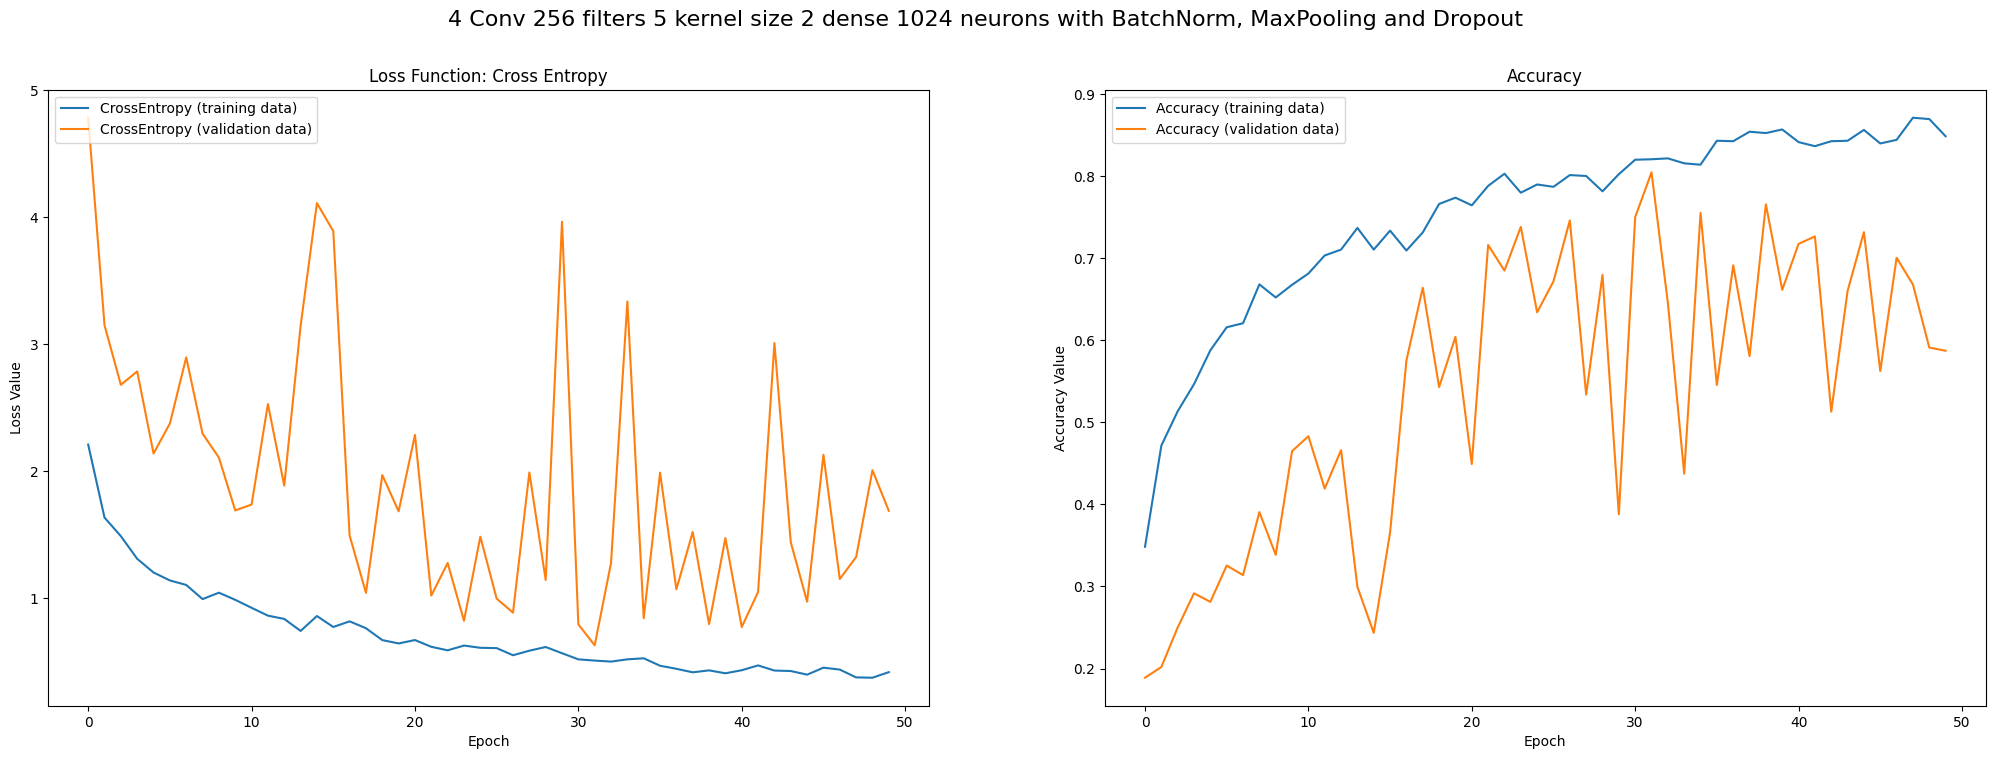

Train Accuracy: 0.5332  Train Loss: 1.9579
Test Accuracy: 0.5836  Test Loss: 1.6928


In [40]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons with BatchNorm, MaxPooling and Dropout".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

# Checking Kernel Size

#### 3 Kernel Size

In [37]:
N_CONV  = 4
CONV = 256
KERNEL = 3
N_DENSE = 2
DENSE = 1024
DROPOUT = True
BATCH_NORM = False
MAX_POOLING = False

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, batch_norm = BATCH_NORM, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE,  verbose = 0)

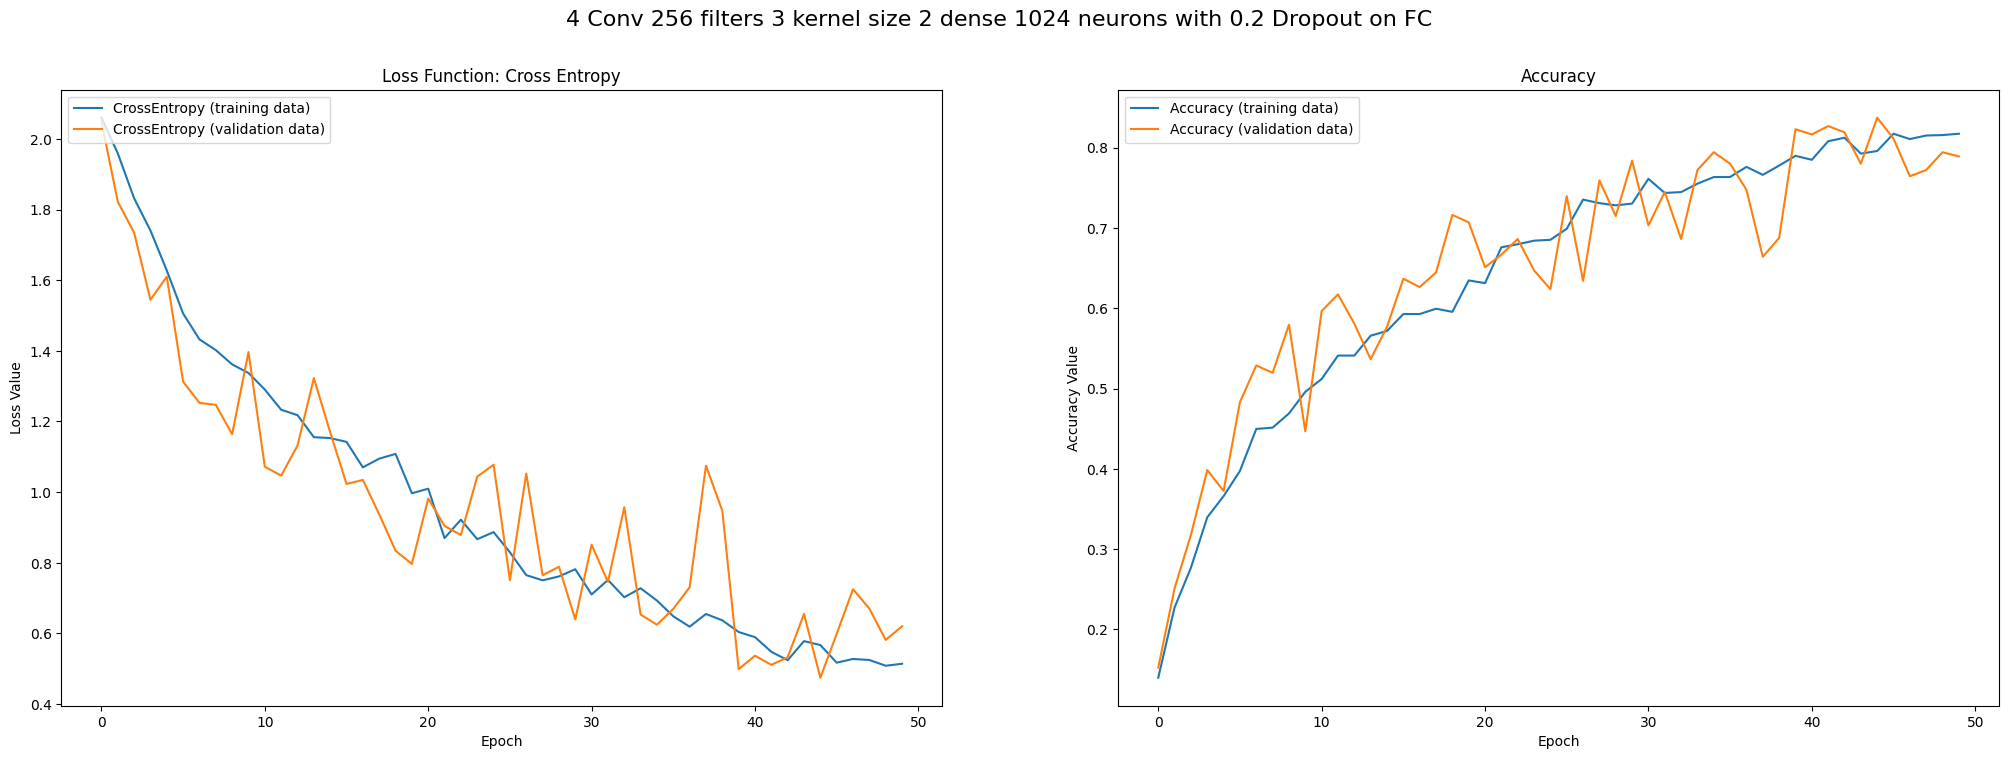

Train Accuracy: 0.8309  Train Loss: 0.4694
Test Accuracy: 0.7856  Test Loss: 0.6261


In [38]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons with 0.2 Dropout on FC".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

#### 7 Kernel Size

In [39]:
N_CONV  = 4
CONV = 256
KERNEL = 7
N_DENSE = 2
DENSE = 1024
DROPOUT = True
BATCH_NORM = False
MAX_POOLING = False

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, batch_norm = BATCH_NORM, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE,  verbose = 0)

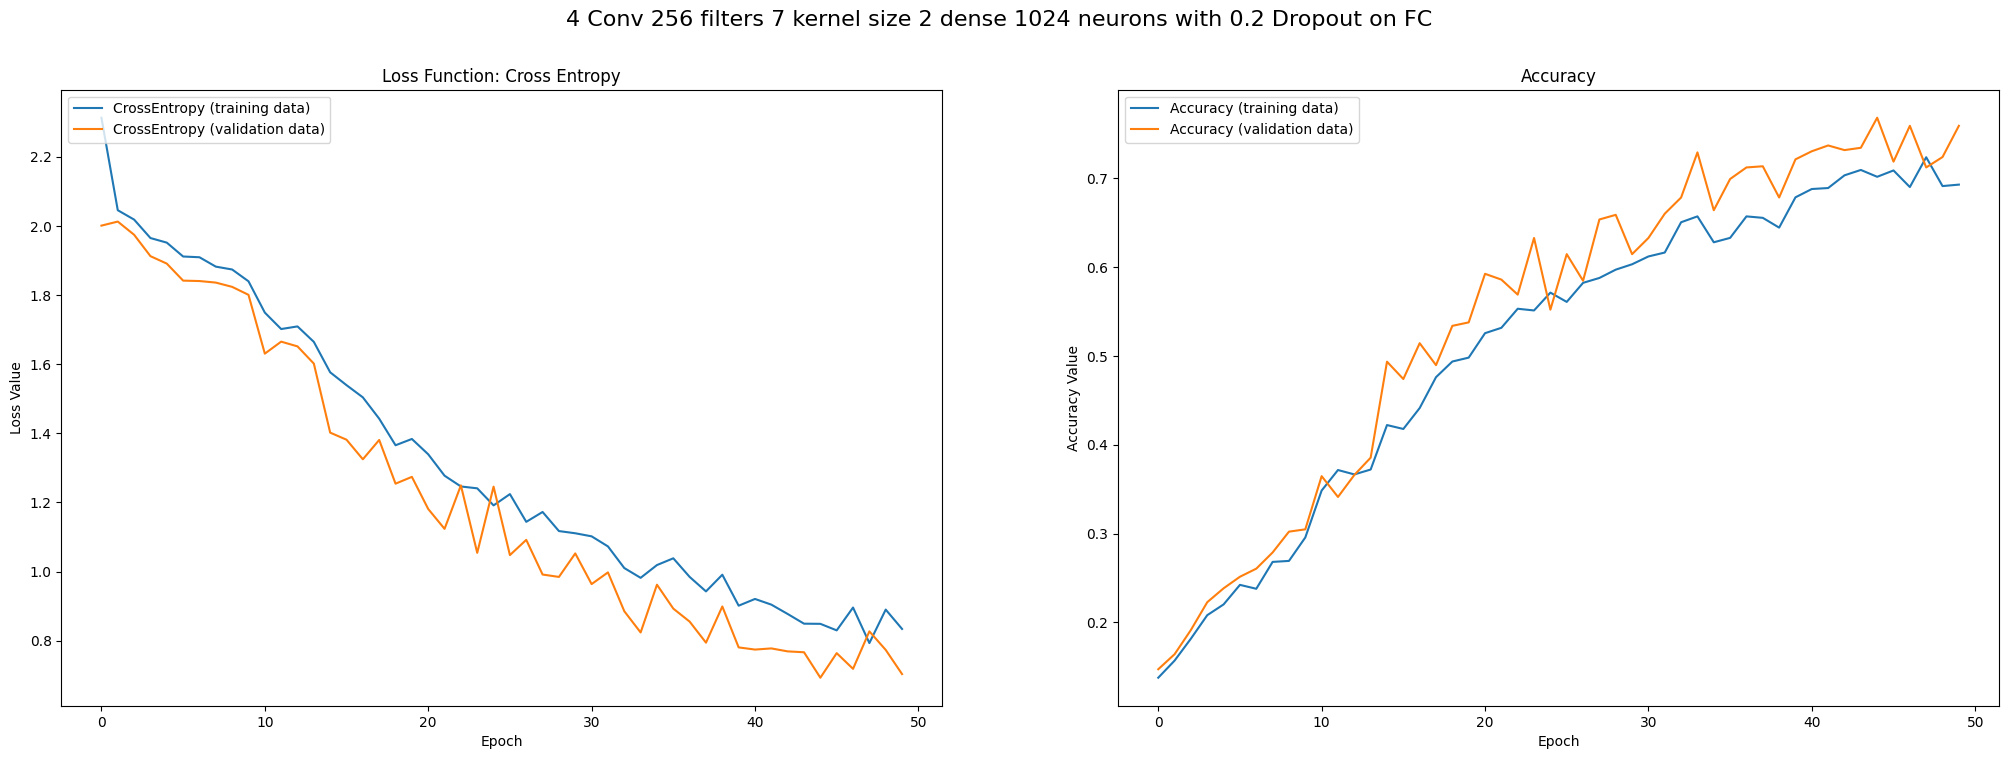

Train Accuracy: 0.7305  Train Loss: 0.7837
Test Accuracy: 0.7546  Test Loss: 0.7194


In [40]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons with 0.2 Dropout on FC".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

#### 9 Kernel Size

In [41]:
N_CONV  = 4
CONV = 256
KERNEL = 9
N_DENSE = 2
DENSE = 1024
DROPOUT = True
BATCH_NORM = False
MAX_POOLING = False

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, batch_norm = BATCH_NORM, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE,  verbose = 0)

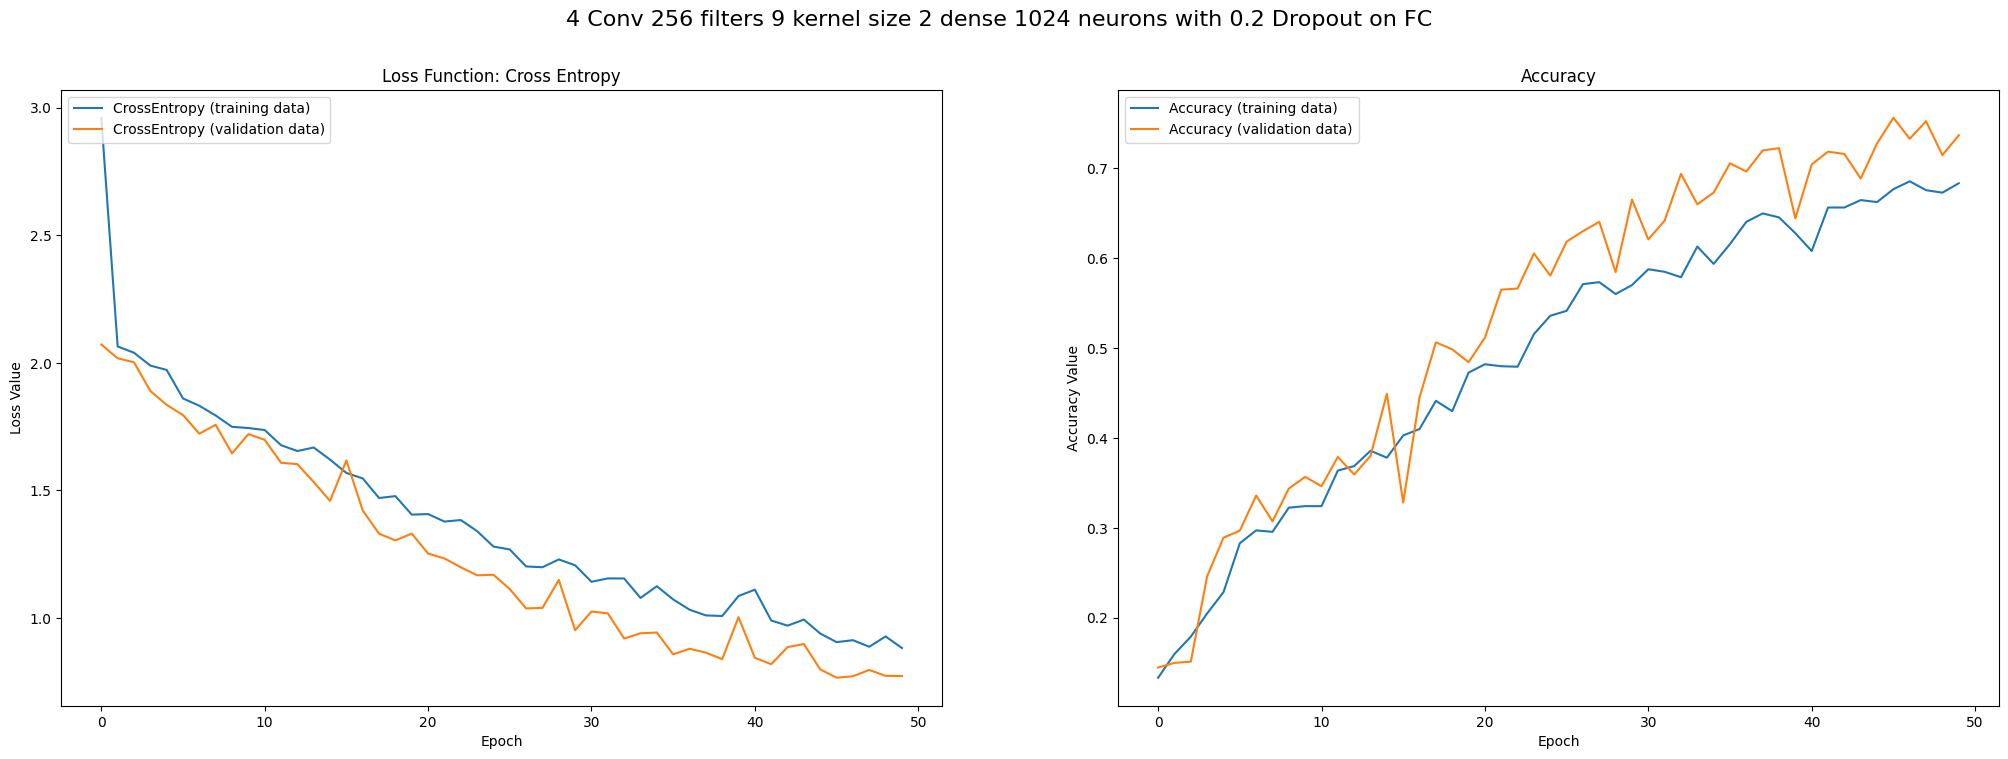

Train Accuracy: 0.7007  Train Loss: 0.8669
Test Accuracy: 0.7348  Test Loss: 0.7784


In [42]:
title = "{} Conv {} filters {} kernel size {} dense {} neurons with 0.2 Dropout on FC".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE)
plot_loss_accuracy(history, title)
experiment.append(title)
(loss, acc) = model.evaluate(train_big, verbose = 0)
results["Train Accuracy"].append(acc)
results["Train Loss"].append(loss)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
results["Test Accuracy"].append(acc)
results["Test Loss"].append(loss)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

## Summarizing all the experiments

In [57]:
calculated = True

if not calculated:
    df = pd.DataFrame.from_dict(results)
    df.index = experiment
else:
    df = pd.read_csv('/home/jlopezcamu/shared/Experiments/results.csv',sep = ",",index_col=0)    
    
    
    if len(results) > 0:
        new_df = pd.DataFrame.from_dict(results)
        new_df.index = experiment        
        df = pd.concat([df, new_df])


    
df

,Train Accuracy,Train Loss,Test Accuracy,Test Loss
1 Conv 64 filters 5 kernel size 1 dense 1024 neurons,62.7326,1.0624,66.0471,0.9706
2 Conv 64 filters 5 kernel size 1 dense 1024 neurons,69.6970,0.8855,70.7559,0.8397
4 Conv 64 filters 5 kernel size 1 dense 1024 neurons,80.3296,0.5649,79.6778,0.5880
8 Conv 64 filters 5 kernel size 1 dense 1024 neurons,75.4918,0.7137,76.4560,0.6602
4 Conv 64 filters 5 kernel size 2 dense 1024 neurons,82.5093,0.5040,81.9083,0.5628
4 Conv 64 filters 5 kernel size 4 dense 1024 neurons,15.5237,2.0707,14.6221,2.0698
4 Conv 32 filters 5 kernel size 2 dense 1024 neurons,76.5019,0.6550,77.9430,0.6572
4 Conv 128 filters 5 kernel size 2 dense 1024 neurons,80.6486,0.5612,81.7844,0.5847
4 Conv 256 filters 5 kernel size 2 dense 1024 neurons,82.2967,0.5104,83.3953,0.5113
4 Conv 256 filters 5 kernel size 2 dense 1024 neurons with MaxPooling,78.5752,0.6283,77.3234,0.7044


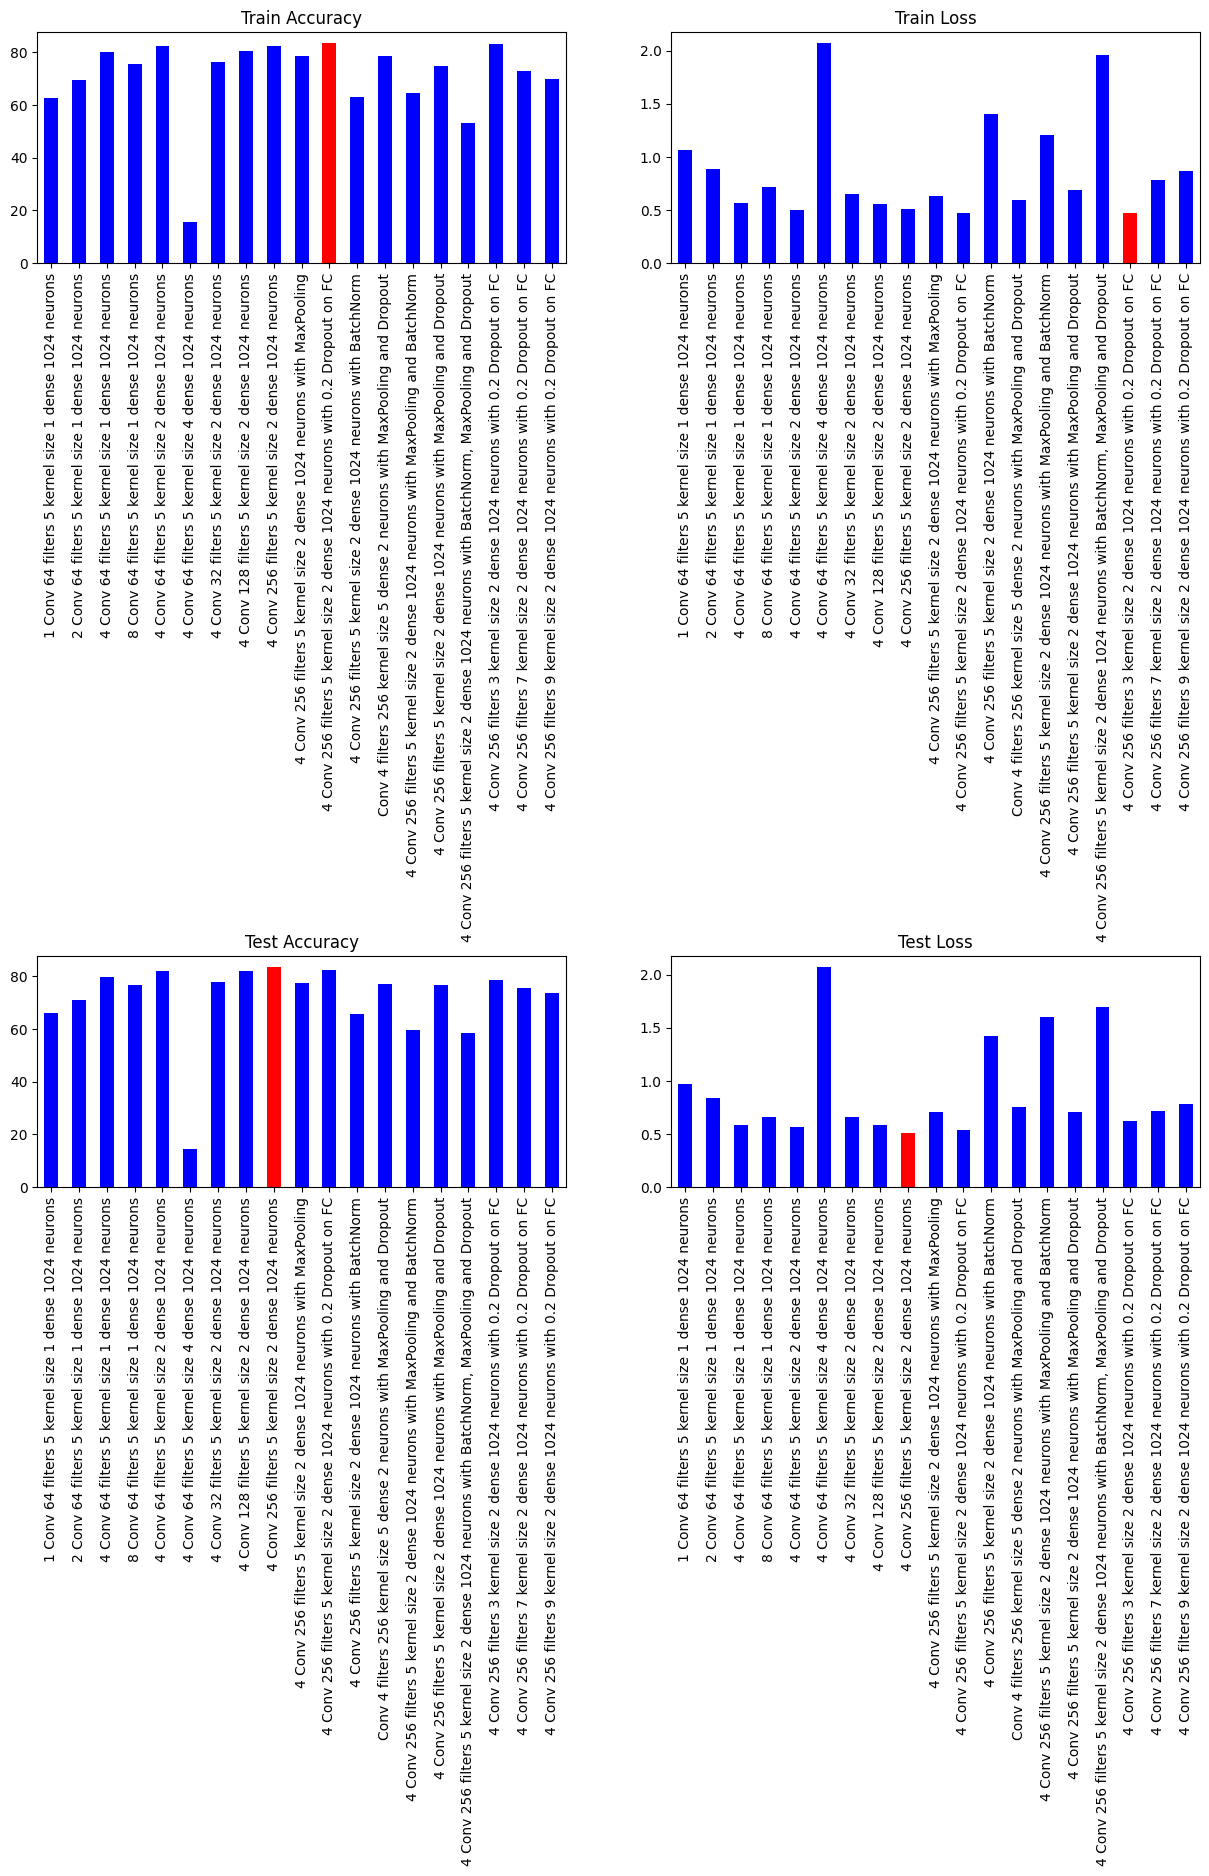

In [90]:
fig, axes = plt.subplots(nrows=2, ncols=2)
x = 0
fig.subplots_adjust(hspace=3)

for i, col in enumerate(df.columns):
    c = df[col]
    if "Accuracy" in col:
        colors = ["r" if val == np.max(c) else "b" for val in c]
    else:
        colors = ["r" if val == np.min(c) else "b" for val in c]
        
    if i == 2:
        x = 1
    i = i % 2
            
    c.plot(kind="bar", figsize=(15,15), title=col, ax=axes[x,i], color=colors)
plt.show()